In [1]:
from __future__ import print_function, division
import torch
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import datanewn as dt
import model_ResUGAN as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader
from pytorch_msssim import msssim
from torch.autograd import Variable

In [2]:
# print gpu
torch.cuda.set_device(0)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:1')
else:
    device = "cpu"
print(device)

Current GPU: 0
8
(7, 0)
1.0.0
cuda:1


Number of Patches: 323906
pancreatic tumor 2000 - 60_norescale_68.jpeg
/deepdata/adib/HEtoSHG/cs766/Data/screened/image_files.csv
323905
0 torch.Size([300, 3, 128, 128]) torch.Size([300, 128, 128])
1 torch.Size([300, 3, 128, 128]) torch.Size([300, 128, 128])
2 torch.Size([300, 3, 128, 128]) torch.Size([300, 128, 128])
3 torch.Size([300, 3, 128, 128]) torch.Size([300, 128, 128])
torch.Size([300, 1, 128, 128])


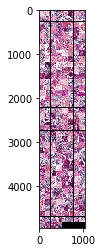

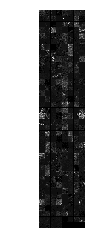

In [12]:
# generate csv file, run only for the first time
import csvgenerator as csvg
# csvg.generate_csv(True)

csvFilePath = csvg.get_csv_path(True)
print(csvFilePath)
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(128),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=300,
                        shuffle=True, num_workers=0)
print(len(transformed_dataset))

# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader)

In [4]:
import os
# cwd = os.getcwd();
# path = os.path.join(cwd, 'Saved model', 'ResUGAN.pth')
# model = md.Net()
# model.load_state_dict(torch.load(path))
# model.eval()


# criterionBCE = nn.BCELoss()
# criterionBCE = criterionBCE.to(device)

imgshape = (128, 128)
patch = (1, 128 // 2 ** 4, 128 // 2 ** 4)
generator = md.GeneratorUNet()
discriminator = md.DiscriminatorPix()
# feature_extractor = md.FeatureExtractor()
# feature_extractor.eval()
optimizer_G = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

In [ ]:
# cwd = os.getcwd();
# path = os.path.join(cwd, 'Saved model', 'GAN_output', 'L1_MSSSIM.pth')
# generator.load_state_dict(torch.load(path))
# generator.eval()
# pathd = os.path.join(cwd, 'Saved model', 'GAN_output', 'trained_discriminator.pth')
# discriminator.load_state_dict(torch.load(pathd))

In [5]:
cwd = os.getcwd();
path = os.path.join(cwd, 'Saved model', 'GAN_output', 'trained_generator.pth')
gpu_ids = [1, 2, 3, 4, 5, 6]
torch.cuda.set_device(gpu_ids[0])
generator = md.GeneratorUNet()
generator = torch.nn.DataParallel(generator, device_ids=gpu_ids)
generator.load_state_dict(torch.load(path))
generator.eval()
generator = generator.cuda()
criterionL = nn.L1Loss()
criterionL = criterionL.to(device)
criterionMSE = nn.MSELoss()
criterionMSE = criterionMSE.to(device)

In [6]:
generator.to(device)
# discriminator.to(device)
# feature_extractor.to(device)

DataParallel(
  (module): GeneratorUNet(
    (down1): UNetDown(
      (model): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (4): LeakyReLU(negative_slope=0.1)
      )
      (side): Sequential(
        (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2), bias=False)
      )
    )
    (skip1): SkipBlock(
      (skip): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.1)
        (3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): LeakyReLU(negative_sl

In [7]:
cwd = os.getcwd();
save_path = os.path.join(cwd, 'Saved model','GAN_output')
Save_generator_path=os.path.join(save_path,'trained_generator.pth')
# Save_discriminator_path=os.path.join(save_path,'trained_discriminator.pth')
Tensor = torch.cuda.FloatTensor

In [8]:
def trainMS(epoch, p, windowsize, trainingspeed):
    epoch_loss_G = 0
    epoch_loss_D = 0
    trainingspeed = trainingspeed
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)
        
        imgs_input = Variable(input.type(Tensor))
        imgs_target = Variable(target.type(Tensor))
        
        valid = Variable(Tensor(np.ones((imgs_input.size(0), *patch))), requires_grad=False)
        fake = Variable(Tensor(np.zeros((imgs_input.size(0), *patch))), requires_grad=False)
        
        #--------
        # train generator
        #--------
        optimizer_G.zero_grad()
        
        gen_target = generator(imgs_input)
        targetf = target.float()
        targetf = targetf[:, None]
        gen_target3d = torch.ones((56, 3, 128, 128), dtype=torch.float)
        gen_target3d = torch.cat((gen_target, gen_target, gen_target),1)
        target3d = torch.ones((56, 3, 128, 128), dtype=torch.float)
        target3d = torch.cat((targetf, targetf, targetf),1)
#         print(gen_target3d.size())
        
        # adversarial loss
        predictions = discriminator(gen_target3d, imgs_input)
        lossGAN = criterionMSE(predictions, valid)
        
        # content loss
#         gen_features = feature_extractor(gen_target3d)
#         real_features = feature_extractor(target3d)
        lossL1 = criterionL(gen_target, targetf)
        lossSSIM = 1-ssim(gen_target, targetf, window_size=windowsize)
        lossContent = p*lossL1 + (1-p)*lossSSIM
        
        # total loss
        loss_G = 100*lossContent + lossGAN
        
        loss_G.backward()
        optimizer_G.step()
        
        
        if iteration%trainingspeed == 0:
        #--------
        # train discriminator
        #--------
            optimizer_D.zero_grad()
        
        # loss of real and fake images
            loss_real = criterionMSE(discriminator(target3d, imgs_input), valid)
            loss_fake = criterionMSE(discriminator(gen_target3d.detach(), imgs_input), fake)
        
        # Total loss
            loss_D = (loss_real + loss_fake) / 2       
        
            loss_D.backward()
            optimizer_D.step()
        
#         if loss_D.item() < 0.15:
#             trainingspeed = 200
#         if loss_D.item() > 0.15:
#             trainingspeed = 50
        
        epoch_loss_G = epoch_loss_G + loss_G
        epoch_loss_D = epoch_loss_D + loss_D
        
        if iteration%200 == 0:
            print("Dloss: " + str(loss_D.item()) + " Gloss: " + str(loss_G.item()) + 
                "    L1: " + str(lossL1.item()) + "    SSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss_G.item()))

    print("===> Epoch {} Complete: Avg. G Loss: {:.4f}".format(epoch, epoch_loss_G / len(dataloader)))
    print("===> Epoch {} Complete: Avg. D Loss: {:.4f}".format(epoch, epoch_loss_D / len(dataloader)))
    torch.save(generator.state_dict(), Save_generator_path)
    torch.save(discriminator.state_dict(), Save_discriminator_path)

In [9]:
def trainG(epoch, p, windowsize):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].float().to(device), batch['output'].float().to(device)

#         imgs_input = Variable(input.type(Tensor))
#         input = input.float()
#         input = input.to(device)
#         targetf = target.float()
        target = target[:, None]
#         targetf = targetf.to(device)
        optimizer.zero_grad()
        output = generator(input)
#         output = output.to('cuda:0')
#         targetf = targetf.to('cuda:0')
        
        lossMSE = criterionL(output, target)      
        lossSSIM = 1-ssim(output, target, window_size=windowsize)
        
        # 0.75->0.4 after 3 epochs
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossL1: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))
    torch.save(generator.state_dict(), Save_generator_path)

In [15]:
torch.save(generator.state_dict(), Save_generator_path)
# torch.save(discriminator.state_dict(), Save_discriminator_path)

In [10]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
from skimage import exposure
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
            
            imgs_input = Variable(input.type(Tensor))
            prediction = generator(imgs_input) # output
#             prediction = F.tanh(prediction)
            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            input = input[0:32, :, :, :]
            input_batch = input_batch[0:32, :, :, :]
            label_batch = label_batch[0:32, :, :]
            
            batch_size = 32
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           
            grid = utils.make_grid(input).cpu()
            input_heimg = grid.numpy().transpose((1, 2, 0))
            plt.imshow(input_heimg)
            plt.figure()
    
            grid = utils.make_grid(input_batch).cpu()
            prediction_shgimg = np.clip(grid.numpy().transpose((1, 2, 0)), 0, 1)
            print(np.amin(prediction_shgimg))
#             prediction_shgimg = exposure.rescale_intensity(prediction_shgimg, out_range=(0, 1))
            prediction_shgimg = exposure.adjust_gamma(prediction_shgimg, 0.8)
            plt.imshow(prediction_shgimg)
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            label_shgimg = grid.numpy().transpose((1, 2, 0))
            plt.imshow(label_shgimg)

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            if iteration == 16:
                break

In [ ]:
# import os
# cwd = os.getcwd();
# path = os.path.join(cwd, 'Saved model', 'Unet0418_1.pth')
# torch.save(generator.state_dict(), path)
# cwd = os.getcwd();
# path = os.path.join(cwd, 'Saved model', 'GPix0418_1.pth')
# torch.save(discriminator.state_dict(), path)

In [ ]:
# cwd = os.getcwd();
# path = os.path.join(cwd, 'Saved model', 'Unet0418.pth')
# generator = md.GeneratorUNet()
# generator.load_state_dict(torch.load(path))
# generator.eval()

In [16]:
p = 0.0
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
# generator.apply(md.weights_init_normal)
# discriminator.apply(md.weights_init_normal)
# Save_generator_path=os.path.join(save_path)

windowsize = 11
for epoch in range(1, 200 + 1):
        
    trainG(epoch, p, windowsize)

lossL1: 0.029645871371030807 lossSSIM: 0.3049435019493103
===> Epoch[1](0/1080): Loss: 0.3049
lossL1: 0.029225168749690056 lossSSIM: 0.305597186088562
===> Epoch[1](50/1080): Loss: 0.3056
lossL1: 0.02901049330830574 lossSSIM: 0.2905311584472656
===> Epoch[1](100/1080): Loss: 0.2905
lossL1: 0.030460745096206665 lossSSIM: 0.31465697288513184
===> Epoch[1](150/1080): Loss: 0.3147
lossL1: 0.02929062768816948 lossSSIM: 0.30589282512664795
===> Epoch[1](200/1080): Loss: 0.3059
lossL1: 0.030018091201782227 lossSSIM: 0.31710493564605713
===> Epoch[1](250/1080): Loss: 0.3171
lossL1: 0.031078554689884186 lossSSIM: 0.3259749412536621
===> Epoch[1](300/1080): Loss: 0.3260
lossL1: 0.029991699382662773 lossSSIM: 0.3140649199485779
===> Epoch[1](350/1080): Loss: 0.3141
lossL1: 0.032596174627542496 lossSSIM: 0.3467990756034851
===> Epoch[1](400/1080): Loss: 0.3468
lossL1: 0.029149536043405533 lossSSIM: 0.3057781457901001
===> Epoch[1](450/1080): Loss: 0.3058
lossL1: 0.02917102724313736 lossSSIM: 0.309

lossL1: 0.030984483659267426 lossSSIM: 0.3218533992767334
===> Epoch[4](950/1080): Loss: 0.3219
lossL1: 0.030295947566628456 lossSSIM: 0.3033127784729004
===> Epoch[4](1000/1080): Loss: 0.3033
lossL1: 0.03107278235256672 lossSSIM: 0.3154158592224121
===> Epoch[4](1050/1080): Loss: 0.3154
===> Epoch 4 Complete: Avg. Loss: 0.3106
lossL1: 0.029558133333921432 lossSSIM: 0.2893444895744324
===> Epoch[5](0/1080): Loss: 0.2893
lossL1: 0.029266690835356712 lossSSIM: 0.3051888942718506
===> Epoch[5](50/1080): Loss: 0.3052
lossL1: 0.030572179704904556 lossSSIM: 0.31553399562835693
===> Epoch[5](100/1080): Loss: 0.3155
lossL1: 0.029426520690321922 lossSSIM: 0.30673861503601074
===> Epoch[5](150/1080): Loss: 0.3067
lossL1: 0.029916591942310333 lossSSIM: 0.3084842562675476
===> Epoch[5](200/1080): Loss: 0.3085
lossL1: 0.029249966144561768 lossSSIM: 0.3100917339324951
===> Epoch[5](250/1080): Loss: 0.3101
lossL1: 0.02789881080389023 lossSSIM: 0.30411428213119507
===> Epoch[5](300/1080): Loss: 0.3041

lossL1: 0.030430614948272705 lossSSIM: 0.3169358968734741
===> Epoch[8](750/1080): Loss: 0.3169
lossL1: 0.031233130022883415 lossSSIM: 0.3185960054397583
===> Epoch[8](800/1080): Loss: 0.3186
lossL1: 0.03003576211631298 lossSSIM: 0.31019556522369385
===> Epoch[8](850/1080): Loss: 0.3102
lossL1: 0.03236297145485878 lossSSIM: 0.32623571157455444
===> Epoch[8](900/1080): Loss: 0.3262
lossL1: 0.030049610882997513 lossSSIM: 0.3000526428222656
===> Epoch[8](950/1080): Loss: 0.3001
lossL1: 0.030087467283010483 lossSSIM: 0.31090247631073
===> Epoch[8](1000/1080): Loss: 0.3109
lossL1: 0.031377699226140976 lossSSIM: 0.32262879610061646
===> Epoch[8](1050/1080): Loss: 0.3226
===> Epoch 8 Complete: Avg. Loss: 0.3092
lossL1: 0.02966374158859253 lossSSIM: 0.30493515729904175
===> Epoch[9](0/1080): Loss: 0.3049
lossL1: 0.02957429550588131 lossSSIM: 0.3266323208808899
===> Epoch[9](50/1080): Loss: 0.3266
lossL1: 0.027585793286561966 lossSSIM: 0.3021298050880432
===> Epoch[9](100/1080): Loss: 0.3021
lo

lossL1: 0.030255937948822975 lossSSIM: 0.2993718385696411
===> Epoch[12](550/1080): Loss: 0.2994
lossL1: 0.029159199446439743 lossSSIM: 0.303861141204834
===> Epoch[12](600/1080): Loss: 0.3039
lossL1: 0.02795254997909069 lossSSIM: 0.29401451349258423
===> Epoch[12](650/1080): Loss: 0.2940
lossL1: 0.030133701860904694 lossSSIM: 0.3138498067855835
===> Epoch[12](700/1080): Loss: 0.3138
lossL1: 0.028751926496624947 lossSSIM: 0.29690998792648315
===> Epoch[12](750/1080): Loss: 0.2969
lossL1: 0.028347641229629517 lossSSIM: 0.29330724477767944
===> Epoch[12](800/1080): Loss: 0.2933
lossL1: 0.028957007452845573 lossSSIM: 0.30716949701309204
===> Epoch[12](850/1080): Loss: 0.3072
lossL1: 0.028901679441332817 lossSSIM: 0.3009907603263855
===> Epoch[12](900/1080): Loss: 0.3010
lossL1: 0.02961113676428795 lossSSIM: 0.3255762457847595
===> Epoch[12](950/1080): Loss: 0.3256
lossL1: 0.026695702224969864 lossSSIM: 0.28182196617126465
===> Epoch[12](1000/1080): Loss: 0.2818
lossL1: 0.02880827523767948

lossL1: 0.028532685711979866 lossSSIM: 0.2886360287666321
===> Epoch[16](300/1080): Loss: 0.2886
lossL1: 0.02834448777139187 lossSSIM: 0.2876237630844116
===> Epoch[16](350/1080): Loss: 0.2876
lossL1: 0.02853913977742195 lossSSIM: 0.3025755286216736
===> Epoch[16](400/1080): Loss: 0.3026
lossL1: 0.029906820505857468 lossSSIM: 0.29927825927734375
===> Epoch[16](450/1080): Loss: 0.2993
lossL1: 0.0305497869849205 lossSSIM: 0.3176179528236389
===> Epoch[16](500/1080): Loss: 0.3176
lossL1: 0.029477570205926895 lossSSIM: 0.3045140504837036
===> Epoch[16](550/1080): Loss: 0.3045
lossL1: 0.0295693501830101 lossSSIM: 0.31771284341812134
===> Epoch[16](600/1080): Loss: 0.3177
lossL1: 0.03016638197004795 lossSSIM: 0.30738115310668945
===> Epoch[16](650/1080): Loss: 0.3074
lossL1: 0.028679680079221725 lossSSIM: 0.31331294775009155
===> Epoch[16](700/1080): Loss: 0.3133
lossL1: 0.029533036053180695 lossSSIM: 0.31528186798095703
===> Epoch[16](750/1080): Loss: 0.3153
lossL1: 0.027610693126916885 los

lossL1: 0.02677832543849945 lossSSIM: 0.2764135003089905
===> Epoch[20](50/1080): Loss: 0.2764
lossL1: 0.02860763482749462 lossSSIM: 0.3052089810371399
===> Epoch[20](100/1080): Loss: 0.3052
lossL1: 0.0289387796074152 lossSSIM: 0.3031323552131653
===> Epoch[20](150/1080): Loss: 0.3031
lossL1: 0.02887115441262722 lossSSIM: 0.2970183491706848
===> Epoch[20](200/1080): Loss: 0.2970
lossL1: 0.028692804276943207 lossSSIM: 0.3083498477935791
===> Epoch[20](250/1080): Loss: 0.3083
lossL1: 0.029474055394530296 lossSSIM: 0.32167840003967285
===> Epoch[20](300/1080): Loss: 0.3217
lossL1: 0.030148277059197426 lossSSIM: 0.3045889735221863
===> Epoch[20](350/1080): Loss: 0.3046
lossL1: 0.02756011299788952 lossSSIM: 0.29782235622406006
===> Epoch[20](400/1080): Loss: 0.2978
lossL1: 0.029984600841999054 lossSSIM: 0.30630648136138916
===> Epoch[20](450/1080): Loss: 0.3063
lossL1: 0.029388723894953728 lossSSIM: 0.3029022812843323
===> Epoch[20](500/1080): Loss: 0.3029
lossL1: 0.028788791969418526 lossS

lossL1: 0.03024597093462944 lossSSIM: 0.3182150721549988
===> Epoch[23](950/1080): Loss: 0.3182
lossL1: 0.03079940751194954 lossSSIM: 0.32108110189437866
===> Epoch[23](1000/1080): Loss: 0.3211
lossL1: 0.02782641351222992 lossSSIM: 0.2962515950202942
===> Epoch[23](1050/1080): Loss: 0.2963
===> Epoch 23 Complete: Avg. Loss: 0.3038
lossL1: 0.030476165935397148 lossSSIM: 0.3213016986846924
===> Epoch[24](0/1080): Loss: 0.3213
lossL1: 0.0284020584076643 lossSSIM: 0.29484671354293823
===> Epoch[24](50/1080): Loss: 0.2948
lossL1: 0.028703419491648674 lossSSIM: 0.31214380264282227
===> Epoch[24](100/1080): Loss: 0.3121
lossL1: 0.028379665687680244 lossSSIM: 0.30024534463882446
===> Epoch[24](150/1080): Loss: 0.3002
lossL1: 0.03067314438521862 lossSSIM: 0.3240883946418762
===> Epoch[24](200/1080): Loss: 0.3241
lossL1: 0.03078637830913067 lossSSIM: 0.3132026195526123
===> Epoch[24](250/1080): Loss: 0.3132
lossL1: 0.029466070234775543 lossSSIM: 0.3051356077194214
===> Epoch[24](300/1080): Loss:

lossL1: 0.028491808101534843 lossSSIM: 0.3195139169692993
===> Epoch[27](700/1080): Loss: 0.3195
lossL1: 0.030297288671135902 lossSSIM: 0.3211870789527893
===> Epoch[27](750/1080): Loss: 0.3212
lossL1: 0.027028920128941536 lossSSIM: 0.29123079776763916
===> Epoch[27](800/1080): Loss: 0.2912
lossL1: 0.028063131496310234 lossSSIM: 0.29154592752456665
===> Epoch[27](850/1080): Loss: 0.2915
lossL1: 0.02947581559419632 lossSSIM: 0.31001371145248413
===> Epoch[27](900/1080): Loss: 0.3100
lossL1: 0.028973395004868507 lossSSIM: 0.32007819414138794
===> Epoch[27](950/1080): Loss: 0.3201
lossL1: 0.02785143442451954 lossSSIM: 0.2872079014778137
===> Epoch[27](1000/1080): Loss: 0.2872
lossL1: 0.02833680808544159 lossSSIM: 0.3030213713645935
===> Epoch[27](1050/1080): Loss: 0.3030
===> Epoch 27 Complete: Avg. Loss: 0.3021
lossL1: 0.028918737545609474 lossSSIM: 0.3112247586250305
===> Epoch[28](0/1080): Loss: 0.3112
lossL1: 0.028140215203166008 lossSSIM: 0.2905401587486267
===> Epoch[28](50/1080): L

lossL1: 0.030436623841524124 lossSSIM: 0.313213050365448
===> Epoch[31](450/1080): Loss: 0.3132
lossL1: 0.02766166627407074 lossSSIM: 0.2879725694656372
===> Epoch[31](500/1080): Loss: 0.2880
lossL1: 0.030005350708961487 lossSSIM: 0.3125835061073303
===> Epoch[31](550/1080): Loss: 0.3126
lossL1: 0.029437987133860588 lossSSIM: 0.304248571395874
===> Epoch[31](600/1080): Loss: 0.3042
lossL1: 0.027923399582505226 lossSSIM: 0.2954205274581909
===> Epoch[31](650/1080): Loss: 0.2954
lossL1: 0.030382705852389336 lossSSIM: 0.31037741899490356
===> Epoch[31](700/1080): Loss: 0.3104
lossL1: 0.029405349865555763 lossSSIM: 0.30309778451919556
===> Epoch[31](750/1080): Loss: 0.3031
lossL1: 0.025810690596699715 lossSSIM: 0.28050798177719116
===> Epoch[31](800/1080): Loss: 0.2805
lossL1: 0.02998250722885132 lossSSIM: 0.3123341202735901
===> Epoch[31](850/1080): Loss: 0.3123
lossL1: 0.02753465063869953 lossSSIM: 0.28588420152664185
===> Epoch[31](900/1080): Loss: 0.2859
lossL1: 0.028777819126844406 lo

lossL1: 0.027566108852624893 lossSSIM: 0.30242735147476196
===> Epoch[35](200/1080): Loss: 0.3024
lossL1: 0.02812877669930458 lossSSIM: 0.3002093434333801
===> Epoch[35](250/1080): Loss: 0.3002
lossL1: 0.026900416240096092 lossSSIM: 0.28001266717910767
===> Epoch[35](300/1080): Loss: 0.2800
lossL1: 0.02939082868397236 lossSSIM: 0.3004770278930664
===> Epoch[35](350/1080): Loss: 0.3005
lossL1: 0.027801265940070152 lossSSIM: 0.28854066133499146
===> Epoch[35](400/1080): Loss: 0.2885
lossL1: 0.027972571551799774 lossSSIM: 0.3051694631576538
===> Epoch[35](450/1080): Loss: 0.3052
lossL1: 0.027860375121235847 lossSSIM: 0.29938042163848877
===> Epoch[35](500/1080): Loss: 0.2994
lossL1: 0.028009604662656784 lossSSIM: 0.29300010204315186
===> Epoch[35](550/1080): Loss: 0.2930
lossL1: 0.028411267325282097 lossSSIM: 0.2931612730026245
===> Epoch[35](600/1080): Loss: 0.2932
lossL1: 0.029061388224363327 lossSSIM: 0.30212700366973877
===> Epoch[35](650/1080): Loss: 0.3021
lossL1: 0.0277243554592132

===> Epoch 38 Complete: Avg. Loss: 0.2996
lossL1: 0.029541969299316406 lossSSIM: 0.3027685284614563
===> Epoch[39](0/1080): Loss: 0.3028
lossL1: 0.02834371291100979 lossSSIM: 0.28820347785949707
===> Epoch[39](50/1080): Loss: 0.2882
lossL1: 0.02623281441628933 lossSSIM: 0.27875757217407227
===> Epoch[39](100/1080): Loss: 0.2788
lossL1: 0.028560036793351173 lossSSIM: 0.3026217222213745
===> Epoch[39](150/1080): Loss: 0.3026
lossL1: 0.029401369392871857 lossSSIM: 0.3176634907722473
===> Epoch[39](200/1080): Loss: 0.3177
lossL1: 0.02746249921619892 lossSSIM: 0.29485446214675903
===> Epoch[39](250/1080): Loss: 0.2949
lossL1: 0.029948348179459572 lossSSIM: 0.3127291202545166
===> Epoch[39](300/1080): Loss: 0.3127
lossL1: 0.026058370247483253 lossSSIM: 0.28808891773223877
===> Epoch[39](350/1080): Loss: 0.2881
lossL1: 0.02804766409099102 lossSSIM: 0.30355364084243774
===> Epoch[39](400/1080): Loss: 0.3036
lossL1: 0.028184853494167328 lossSSIM: 0.2913639545440674
===> Epoch[39](450/1080): Los

lossL1: 0.028983650729060173 lossSSIM: 0.31112098693847656
===> Epoch[42](850/1080): Loss: 0.3111
lossL1: 0.02903573028743267 lossSSIM: 0.30043506622314453
===> Epoch[42](900/1080): Loss: 0.3004
lossL1: 0.02868635766208172 lossSSIM: 0.2957128882408142
===> Epoch[42](950/1080): Loss: 0.2957
lossL1: 0.02856859751045704 lossSSIM: 0.300758421421051
===> Epoch[42](1000/1080): Loss: 0.3008
lossL1: 0.028788642957806587 lossSSIM: 0.31110215187072754
===> Epoch[42](1050/1080): Loss: 0.3111
===> Epoch 42 Complete: Avg. Loss: 0.2974
lossL1: 0.028456643223762512 lossSSIM: 0.29857969284057617
===> Epoch[43](0/1080): Loss: 0.2986
lossL1: 0.028084974735975266 lossSSIM: 0.29660671949386597
===> Epoch[43](50/1080): Loss: 0.2966
lossL1: 0.02640197053551674 lossSSIM: 0.2792595624923706
===> Epoch[43](100/1080): Loss: 0.2793
lossL1: 0.029479017481207848 lossSSIM: 0.30892008543014526
===> Epoch[43](150/1080): Loss: 0.3089
lossL1: 0.026627028360962868 lossSSIM: 0.2669905424118042
===> Epoch[43](200/1080): L

lossL1: 0.028781471773982048 lossSSIM: 0.301130473613739
===> Epoch[46](600/1080): Loss: 0.3011
lossL1: 0.026677189394831657 lossSSIM: 0.2923400402069092
===> Epoch[46](650/1080): Loss: 0.2923
lossL1: 0.02854306623339653 lossSSIM: 0.30760276317596436
===> Epoch[46](700/1080): Loss: 0.3076
lossL1: 0.02656114287674427 lossSSIM: 0.2865312099456787
===> Epoch[46](750/1080): Loss: 0.2865
lossL1: 0.026777686551213264 lossSSIM: 0.28536415100097656
===> Epoch[46](800/1080): Loss: 0.2854
lossL1: 0.028143765404820442 lossSSIM: 0.29673439264297485
===> Epoch[46](850/1080): Loss: 0.2967
lossL1: 0.027479149401187897 lossSSIM: 0.28562605381011963
===> Epoch[46](900/1080): Loss: 0.2856
lossL1: 0.028854859992861748 lossSSIM: 0.3045559525489807
===> Epoch[46](950/1080): Loss: 0.3046
lossL1: 0.028181714937090874 lossSSIM: 0.2950702905654907
===> Epoch[46](1000/1080): Loss: 0.2951
lossL1: 0.026359260082244873 lossSSIM: 0.28140175342559814
===> Epoch[46](1050/1080): Loss: 0.2814
===> Epoch 46 Complete: Av

lossL1: 0.028289467096328735 lossSSIM: 0.2952433228492737
===> Epoch[50](350/1080): Loss: 0.2952
lossL1: 0.027478672564029694 lossSSIM: 0.2924976348876953
===> Epoch[50](400/1080): Loss: 0.2925
lossL1: 0.028976459056138992 lossSSIM: 0.3087577819824219
===> Epoch[50](450/1080): Loss: 0.3088
lossL1: 0.028000371530652046 lossSSIM: 0.2940348982810974
===> Epoch[50](500/1080): Loss: 0.2940
lossL1: 0.027620786800980568 lossSSIM: 0.3008536696434021
===> Epoch[50](550/1080): Loss: 0.3009
lossL1: 0.02847890928387642 lossSSIM: 0.29726529121398926
===> Epoch[50](600/1080): Loss: 0.2973
lossL1: 0.02695688232779503 lossSSIM: 0.2845115065574646
===> Epoch[50](650/1080): Loss: 0.2845
lossL1: 0.026404891163110733 lossSSIM: 0.29148054122924805
===> Epoch[50](700/1080): Loss: 0.2915
lossL1: 0.026486696675419807 lossSSIM: 0.28297048807144165
===> Epoch[50](750/1080): Loss: 0.2830
lossL1: 0.02939450554549694 lossSSIM: 0.30702394247055054
===> Epoch[50](800/1080): Loss: 0.3070
lossL1: 0.027939647436141968 

lossL1: 0.02778787910938263 lossSSIM: 0.29134565591812134
===> Epoch[54](100/1080): Loss: 0.2913
lossL1: 0.028642838820815086 lossSSIM: 0.30167287588119507
===> Epoch[54](150/1080): Loss: 0.3017
lossL1: 0.0278690904378891 lossSSIM: 0.3005669116973877
===> Epoch[54](200/1080): Loss: 0.3006
lossL1: 0.02910863235592842 lossSSIM: 0.31397169828414917
===> Epoch[54](250/1080): Loss: 0.3140
lossL1: 0.02739652618765831 lossSSIM: 0.2983449697494507
===> Epoch[54](300/1080): Loss: 0.2983
lossL1: 0.028191648423671722 lossSSIM: 0.29800909757614136
===> Epoch[54](350/1080): Loss: 0.2980
lossL1: 0.02819112129509449 lossSSIM: 0.2965507507324219
===> Epoch[54](400/1080): Loss: 0.2966
lossL1: 0.028949454426765442 lossSSIM: 0.30321282148361206
===> Epoch[54](450/1080): Loss: 0.3032
lossL1: 0.027770888060331345 lossSSIM: 0.29794222116470337
===> Epoch[54](500/1080): Loss: 0.2979
lossL1: 0.02770659141242504 lossSSIM: 0.28843724727630615
===> Epoch[54](550/1080): Loss: 0.2884
lossL1: 0.026959586888551712 l

lossL1: 0.030139653012156487 lossSSIM: 0.316178560256958
===> Epoch[57](1000/1080): Loss: 0.3162
lossL1: 0.02865459769964218 lossSSIM: 0.293623149394989
===> Epoch[57](1050/1080): Loss: 0.2936
===> Epoch 57 Complete: Avg. Loss: 0.2934
lossL1: 0.02777315117418766 lossSSIM: 0.286673367023468
===> Epoch[58](0/1080): Loss: 0.2867
lossL1: 0.029069067910313606 lossSSIM: 0.3036491274833679
===> Epoch[58](50/1080): Loss: 0.3036
lossL1: 0.02793227508664131 lossSSIM: 0.3034612536430359
===> Epoch[58](100/1080): Loss: 0.3035
lossL1: 0.029367364943027496 lossSSIM: 0.299193799495697
===> Epoch[58](150/1080): Loss: 0.2992
lossL1: 0.029085727408528328 lossSSIM: 0.30441856384277344
===> Epoch[58](200/1080): Loss: 0.3044
lossL1: 0.02762213721871376 lossSSIM: 0.2979227900505066
===> Epoch[58](250/1080): Loss: 0.2979
lossL1: 0.02856394462287426 lossSSIM: 0.3014770746231079
===> Epoch[58](300/1080): Loss: 0.3015
lossL1: 0.02710738219320774 lossSSIM: 0.2931184768676758
===> Epoch[58](350/1080): Loss: 0.293

lossL1: 0.029285741969943047 lossSSIM: 0.305286705493927
===> Epoch[61](800/1080): Loss: 0.3053
lossL1: 0.028257811442017555 lossSSIM: 0.29879236221313477
===> Epoch[61](850/1080): Loss: 0.2988
lossL1: 0.028684718534350395 lossSSIM: 0.2956445813179016
===> Epoch[61](900/1080): Loss: 0.2956
lossL1: 0.026966139674186707 lossSSIM: 0.28335702419281006
===> Epoch[61](950/1080): Loss: 0.2834
lossL1: 0.025114985182881355 lossSSIM: 0.2766590118408203
===> Epoch[61](1000/1080): Loss: 0.2767
lossL1: 0.02708912268280983 lossSSIM: 0.29302871227264404
===> Epoch[61](1050/1080): Loss: 0.2930
===> Epoch 61 Complete: Avg. Loss: 0.2928
lossL1: 0.02686403878033161 lossSSIM: 0.2783241868019104
===> Epoch[62](0/1080): Loss: 0.2783
lossL1: 0.028228390961885452 lossSSIM: 0.29780471324920654
===> Epoch[62](50/1080): Loss: 0.2978
lossL1: 0.02685522474348545 lossSSIM: 0.2900215983390808
===> Epoch[62](100/1080): Loss: 0.2900
lossL1: 0.029276272282004356 lossSSIM: 0.31051409244537354
===> Epoch[62](150/1080): L

lossL1: 0.02508351393043995 lossSSIM: 0.27593666315078735
===> Epoch[65](550/1080): Loss: 0.2759
lossL1: 0.028079181909561157 lossSSIM: 0.2908095121383667
===> Epoch[65](600/1080): Loss: 0.2908
lossL1: 0.026579895988106728 lossSSIM: 0.28339606523513794
===> Epoch[65](650/1080): Loss: 0.2834
lossL1: 0.02754998579621315 lossSSIM: 0.29046177864074707
===> Epoch[65](700/1080): Loss: 0.2905
lossL1: 0.02715791016817093 lossSSIM: 0.28708428144454956
===> Epoch[65](750/1080): Loss: 0.2871
lossL1: 0.027606893330812454 lossSSIM: 0.29278403520584106
===> Epoch[65](800/1080): Loss: 0.2928
lossL1: 0.02863503433763981 lossSSIM: 0.30186307430267334
===> Epoch[65](850/1080): Loss: 0.3019
lossL1: 0.02865232713520527 lossSSIM: 0.2944433093070984
===> Epoch[65](900/1080): Loss: 0.2944
lossL1: 0.027622776105999947 lossSSIM: 0.3012526035308838
===> Epoch[65](950/1080): Loss: 0.3013
lossL1: 0.027549171820282936 lossSSIM: 0.2856031656265259
===> Epoch[65](1000/1080): Loss: 0.2856
lossL1: 0.02625405229628086 

lossL1: 0.026805071160197258 lossSSIM: 0.28596067428588867
===> Epoch[69](300/1080): Loss: 0.2860
lossL1: 0.02777334488928318 lossSSIM: 0.3022001385688782
===> Epoch[69](350/1080): Loss: 0.3022
lossL1: 0.026528583839535713 lossSSIM: 0.2857133746147156
===> Epoch[69](400/1080): Loss: 0.2857
lossL1: 0.02583983726799488 lossSSIM: 0.26712775230407715
===> Epoch[69](450/1080): Loss: 0.2671
lossL1: 0.026454664766788483 lossSSIM: 0.28306347131729126
===> Epoch[69](500/1080): Loss: 0.2831
lossL1: 0.02829398773610592 lossSSIM: 0.2967689037322998
===> Epoch[69](550/1080): Loss: 0.2968
lossL1: 0.026709124445915222 lossSSIM: 0.27853500843048096
===> Epoch[69](600/1080): Loss: 0.2785
lossL1: 0.02895166352391243 lossSSIM: 0.30296874046325684
===> Epoch[69](650/1080): Loss: 0.3030
lossL1: 0.02738453634083271 lossSSIM: 0.2764092683792114
===> Epoch[69](700/1080): Loss: 0.2764
lossL1: 0.028129126876592636 lossSSIM: 0.2999187111854553
===> Epoch[69](750/1080): Loss: 0.2999
lossL1: 0.026905059814453125 l

lossL1: 0.02685447968542576 lossSSIM: 0.2776259779930115
===> Epoch[73](50/1080): Loss: 0.2776
lossL1: 0.02689507231116295 lossSSIM: 0.2835983633995056
===> Epoch[73](100/1080): Loss: 0.2836
lossL1: 0.027054233476519585 lossSSIM: 0.28310292959213257
===> Epoch[73](150/1080): Loss: 0.2831
lossL1: 0.0269346721470356 lossSSIM: 0.28917282819747925
===> Epoch[73](200/1080): Loss: 0.2892
lossL1: 0.0272480808198452 lossSSIM: 0.2878824472427368
===> Epoch[73](250/1080): Loss: 0.2879
lossL1: 0.0260274950414896 lossSSIM: 0.2769623398780823
===> Epoch[73](300/1080): Loss: 0.2770
lossL1: 0.027986863628029823 lossSSIM: 0.29383569955825806
===> Epoch[73](350/1080): Loss: 0.2938
lossL1: 0.02703576348721981 lossSSIM: 0.27844005823135376
===> Epoch[73](400/1080): Loss: 0.2784
lossL1: 0.026055186986923218 lossSSIM: 0.27797651290893555
===> Epoch[73](450/1080): Loss: 0.2780
lossL1: 0.02808564528822899 lossSSIM: 0.2983890771865845
===> Epoch[73](500/1080): Loss: 0.2984
lossL1: 0.02741626650094986 lossSSIM

lossL1: 0.02830931358039379 lossSSIM: 0.29926598072052
===> Epoch[76](950/1080): Loss: 0.2993
lossL1: 0.025188028812408447 lossSSIM: 0.26252925395965576
===> Epoch[76](1000/1080): Loss: 0.2625
lossL1: 0.026926184073090553 lossSSIM: 0.2814779281616211
===> Epoch[76](1050/1080): Loss: 0.2815
===> Epoch 76 Complete: Avg. Loss: 0.2888
lossL1: 0.026374276727437973 lossSSIM: 0.2731666564941406
===> Epoch[77](0/1080): Loss: 0.2732
lossL1: 0.026318872347474098 lossSSIM: 0.2796344757080078
===> Epoch[77](50/1080): Loss: 0.2796
lossL1: 0.027390755712985992 lossSSIM: 0.2932403087615967
===> Epoch[77](100/1080): Loss: 0.2932
lossL1: 0.027037102729082108 lossSSIM: 0.28499627113342285
===> Epoch[77](150/1080): Loss: 0.2850
lossL1: 0.026218658313155174 lossSSIM: 0.2719636559486389
===> Epoch[77](200/1080): Loss: 0.2720
lossL1: 0.026948748156428337 lossSSIM: 0.27939802408218384
===> Epoch[77](250/1080): Loss: 0.2794
lossL1: 0.02737271972000599 lossSSIM: 0.2913283109664917
===> Epoch[77](300/1080): Los

lossL1: 0.02837185561656952 lossSSIM: 0.29859477281570435
===> Epoch[80](700/1080): Loss: 0.2986
lossL1: 0.02681572362780571 lossSSIM: 0.28198838233947754
===> Epoch[80](750/1080): Loss: 0.2820
lossL1: 0.025758974254131317 lossSSIM: 0.2742999792098999
===> Epoch[80](800/1080): Loss: 0.2743
lossL1: 0.028817377984523773 lossSSIM: 0.3024539351463318
===> Epoch[80](850/1080): Loss: 0.3025
lossL1: 0.026749471202492714 lossSSIM: 0.2854616045951843
===> Epoch[80](900/1080): Loss: 0.2855
lossL1: 0.026456862688064575 lossSSIM: 0.2793598771095276
===> Epoch[80](950/1080): Loss: 0.2794
lossL1: 0.028605451807379723 lossSSIM: 0.29165637493133545
===> Epoch[80](1000/1080): Loss: 0.2917
lossL1: 0.025831099599599838 lossSSIM: 0.28349947929382324
===> Epoch[80](1050/1080): Loss: 0.2835
===> Epoch 80 Complete: Avg. Loss: 0.2877
lossL1: 0.0249810628592968 lossSSIM: 0.26061320304870605
===> Epoch[81](0/1080): Loss: 0.2606
lossL1: 0.0274822935461998 lossSSIM: 0.2880018949508667
===> Epoch[81](50/1080): Los

lossL1: 0.026780592277646065 lossSSIM: 0.28145790100097656
===> Epoch[84](450/1080): Loss: 0.2815
lossL1: 0.026528673246502876 lossSSIM: 0.28157860040664673
===> Epoch[84](500/1080): Loss: 0.2816
lossL1: 0.026998329907655716 lossSSIM: 0.284465491771698
===> Epoch[84](550/1080): Loss: 0.2845
lossL1: 0.027533242478966713 lossSSIM: 0.2877769470214844
===> Epoch[84](600/1080): Loss: 0.2878
lossL1: 0.028566109016537666 lossSSIM: 0.2897365093231201
===> Epoch[84](650/1080): Loss: 0.2897
lossL1: 0.027199024334549904 lossSSIM: 0.2932109832763672
===> Epoch[84](700/1080): Loss: 0.2932
lossL1: 0.02636847458779812 lossSSIM: 0.28183889389038086
===> Epoch[84](750/1080): Loss: 0.2818
lossL1: 0.0269980076700449 lossSSIM: 0.28348928689956665
===> Epoch[84](800/1080): Loss: 0.2835
lossL1: 0.025872524827718735 lossSSIM: 0.27594733238220215
===> Epoch[84](850/1080): Loss: 0.2759
lossL1: 0.026675738394260406 lossSSIM: 0.2833396792411804
===> Epoch[84](900/1080): Loss: 0.2833
lossL1: 0.026218008249998093 

lossL1: 0.027283713221549988 lossSSIM: 0.2898731231689453
===> Epoch[88](200/1080): Loss: 0.2899
lossL1: 0.026892773807048798 lossSSIM: 0.2866203784942627
===> Epoch[88](250/1080): Loss: 0.2866
lossL1: 0.027144022285938263 lossSSIM: 0.274469256401062
===> Epoch[88](300/1080): Loss: 0.2745
lossL1: 0.026356017217040062 lossSSIM: 0.28021901845932007
===> Epoch[88](350/1080): Loss: 0.2802
lossL1: 0.02601802907884121 lossSSIM: 0.2805018424987793
===> Epoch[88](400/1080): Loss: 0.2805
lossL1: 0.027851527556777 lossSSIM: 0.2990691065788269
===> Epoch[88](450/1080): Loss: 0.2991
lossL1: 0.02759964019060135 lossSSIM: 0.2908366918563843
===> Epoch[88](500/1080): Loss: 0.2908
lossL1: 0.02932153083384037 lossSSIM: 0.3079248070716858
===> Epoch[88](550/1080): Loss: 0.3079
lossL1: 0.027196388691663742 lossSSIM: 0.2929801344871521
===> Epoch[88](600/1080): Loss: 0.2930
lossL1: 0.027610886842012405 lossSSIM: 0.2934430241584778
===> Epoch[88](650/1080): Loss: 0.2934
lossL1: 0.027394965291023254 lossSSI

===> Epoch 91 Complete: Avg. Loss: 0.2859
lossL1: 0.025707034394145012 lossSSIM: 0.2704048752784729
===> Epoch[92](0/1080): Loss: 0.2704
lossL1: 0.026630019769072533 lossSSIM: 0.28760653734207153
===> Epoch[92](50/1080): Loss: 0.2876
lossL1: 0.027584969997406006 lossSSIM: 0.2973451614379883
===> Epoch[92](100/1080): Loss: 0.2973
lossL1: 0.025890592485666275 lossSSIM: 0.287523090839386
===> Epoch[92](150/1080): Loss: 0.2875
lossL1: 0.026691239327192307 lossSSIM: 0.28230881690979004
===> Epoch[92](200/1080): Loss: 0.2823
lossL1: 0.02820313163101673 lossSSIM: 0.288188636302948
===> Epoch[92](250/1080): Loss: 0.2882
lossL1: 0.027736810967326164 lossSSIM: 0.2960774302482605
===> Epoch[92](300/1080): Loss: 0.2961
lossL1: 0.02584160678088665 lossSSIM: 0.27065205574035645
===> Epoch[92](350/1080): Loss: 0.2707
lossL1: 0.02678746171295643 lossSSIM: 0.27997028827667236
===> Epoch[92](400/1080): Loss: 0.2800
lossL1: 0.026161503046751022 lossSSIM: 0.28892189264297485
===> Epoch[92](450/1080): Loss

lossL1: 0.027527377009391785 lossSSIM: 0.29090744256973267
===> Epoch[95](850/1080): Loss: 0.2909
lossL1: 0.027670923620462418 lossSSIM: 0.2994779944419861
===> Epoch[95](900/1080): Loss: 0.2995
lossL1: 0.02730897255241871 lossSSIM: 0.28790467977523804
===> Epoch[95](950/1080): Loss: 0.2879
lossL1: 0.028374824672937393 lossSSIM: 0.3041263222694397
===> Epoch[95](1000/1080): Loss: 0.3041
lossL1: 0.02664908394217491 lossSSIM: 0.29022157192230225
===> Epoch[95](1050/1080): Loss: 0.2902
===> Epoch 95 Complete: Avg. Loss: 0.2852
lossL1: 0.026865780353546143 lossSSIM: 0.2861502170562744
===> Epoch[96](0/1080): Loss: 0.2862
lossL1: 0.025993915274739265 lossSSIM: 0.2614966034889221
===> Epoch[96](50/1080): Loss: 0.2615
lossL1: 0.025225477293133736 lossSSIM: 0.2703508734703064
===> Epoch[96](100/1080): Loss: 0.2704
lossL1: 0.027744026854634285 lossSSIM: 0.2787718176841736
===> Epoch[96](150/1080): Loss: 0.2788
lossL1: 0.026476344093680382 lossSSIM: 0.28235042095184326
===> Epoch[96](200/1080): 

lossL1: 0.028493138030171394 lossSSIM: 0.295596718788147
===> Epoch[99](600/1080): Loss: 0.2956
lossL1: 0.027380049228668213 lossSSIM: 0.27140843868255615
===> Epoch[99](650/1080): Loss: 0.2714
lossL1: 0.027611130848526955 lossSSIM: 0.28585952520370483
===> Epoch[99](700/1080): Loss: 0.2859
lossL1: 0.02666066400706768 lossSSIM: 0.28262656927108765
===> Epoch[99](750/1080): Loss: 0.2826
lossL1: 0.02773452363908291 lossSSIM: 0.2963164448738098
===> Epoch[99](800/1080): Loss: 0.2963
lossL1: 0.027498362585902214 lossSSIM: 0.2922699451446533
===> Epoch[99](850/1080): Loss: 0.2923
lossL1: 0.026273084804415703 lossSSIM: 0.28161150217056274
===> Epoch[99](900/1080): Loss: 0.2816
lossL1: 0.026786841452121735 lossSSIM: 0.28046178817749023
===> Epoch[99](950/1080): Loss: 0.2805
lossL1: 0.024270497262477875 lossSSIM: 0.25928163528442383
===> Epoch[99](1000/1080): Loss: 0.2593
lossL1: 0.02607792802155018 lossSSIM: 0.2763557434082031
===> Epoch[99](1050/1080): Loss: 0.2764
===> Epoch 99 Complete: Av

lossL1: 0.027300173416733742 lossSSIM: 0.2922450304031372
===> Epoch[103](300/1080): Loss: 0.2922
lossL1: 0.02615843154489994 lossSSIM: 0.2648429870605469
===> Epoch[103](350/1080): Loss: 0.2648
lossL1: 0.026682835072278976 lossSSIM: 0.2778891324996948
===> Epoch[103](400/1080): Loss: 0.2779
lossL1: 0.02526957355439663 lossSSIM: 0.26345014572143555
===> Epoch[103](450/1080): Loss: 0.2635
lossL1: 0.027026856318116188 lossSSIM: 0.28720396757125854
===> Epoch[103](500/1080): Loss: 0.2872
lossL1: 0.02876516990363598 lossSSIM: 0.30048447847366333
===> Epoch[103](550/1080): Loss: 0.3005
lossL1: 0.02699124626815319 lossSSIM: 0.28994113206863403
===> Epoch[103](600/1080): Loss: 0.2899
lossL1: 0.028477858752012253 lossSSIM: 0.29992711544036865
===> Epoch[103](650/1080): Loss: 0.2999
lossL1: 0.02600579336285591 lossSSIM: 0.27062302827835083
===> Epoch[103](700/1080): Loss: 0.2706
lossL1: 0.028085384517908096 lossSSIM: 0.2990494966506958
===> Epoch[103](750/1080): Loss: 0.2990
lossL1: 0.025832789

lossL1: 0.026853440329432487 lossSSIM: 0.27804726362228394
===> Epoch[107](0/1080): Loss: 0.2780
lossL1: 0.025207646191120148 lossSSIM: 0.27085453271865845
===> Epoch[107](50/1080): Loss: 0.2709
lossL1: 0.025201955810189247 lossSSIM: 0.2732774615287781
===> Epoch[107](100/1080): Loss: 0.2733
lossL1: 0.026491940021514893 lossSSIM: 0.2787935733795166
===> Epoch[107](150/1080): Loss: 0.2788
lossL1: 0.02375609427690506 lossSSIM: 0.25203317403793335
===> Epoch[107](200/1080): Loss: 0.2520
lossL1: 0.026878073811531067 lossSSIM: 0.2760527729988098
===> Epoch[107](250/1080): Loss: 0.2761
lossL1: 0.02895580232143402 lossSSIM: 0.2941824793815613
===> Epoch[107](300/1080): Loss: 0.2942
lossL1: 0.026820601895451546 lossSSIM: 0.28281110525131226
===> Epoch[107](350/1080): Loss: 0.2828
lossL1: 0.027092263102531433 lossSSIM: 0.2899130582809448
===> Epoch[107](400/1080): Loss: 0.2899
lossL1: 0.02581312134861946 lossSSIM: 0.2806156277656555
===> Epoch[107](450/1080): Loss: 0.2806
lossL1: 0.027063922956

lossL1: 0.026213878765702248 lossSSIM: 0.2799919843673706
===> Epoch[110](850/1080): Loss: 0.2800
lossL1: 0.026863044127821922 lossSSIM: 0.2901928424835205
===> Epoch[110](900/1080): Loss: 0.2902
lossL1: 0.026298915967345238 lossSSIM: 0.28222227096557617
===> Epoch[110](950/1080): Loss: 0.2822
lossL1: 0.027561161667108536 lossSSIM: 0.29481518268585205
===> Epoch[110](1000/1080): Loss: 0.2948
lossL1: 0.026943264529109 lossSSIM: 0.2888427972793579
===> Epoch[110](1050/1080): Loss: 0.2888
===> Epoch 110 Complete: Avg. Loss: 0.2826
lossL1: 0.02602609246969223 lossSSIM: 0.2760300040245056
===> Epoch[111](0/1080): Loss: 0.2760
lossL1: 0.026829691603779793 lossSSIM: 0.29688823223114014
===> Epoch[111](50/1080): Loss: 0.2969
lossL1: 0.026515327394008636 lossSSIM: 0.28318578004837036
===> Epoch[111](100/1080): Loss: 0.2832
lossL1: 0.027603546157479286 lossSSIM: 0.29869842529296875
===> Epoch[111](150/1080): Loss: 0.2987
lossL1: 0.025952763855457306 lossSSIM: 0.27805525064468384
===> Epoch[111](

lossL1: 0.025709638372063637 lossSSIM: 0.2769838571548462
===> Epoch[114](550/1080): Loss: 0.2770
lossL1: 0.02544816955924034 lossSSIM: 0.2585809826850891
===> Epoch[114](600/1080): Loss: 0.2586
lossL1: 0.02748802863061428 lossSSIM: 0.27160149812698364
===> Epoch[114](650/1080): Loss: 0.2716
lossL1: 0.027596572414040565 lossSSIM: 0.3002190589904785
===> Epoch[114](700/1080): Loss: 0.3002
lossL1: 0.026128819212317467 lossSSIM: 0.27000629901885986
===> Epoch[114](750/1080): Loss: 0.2700
lossL1: 0.02770177461206913 lossSSIM: 0.28772222995758057
===> Epoch[114](800/1080): Loss: 0.2877
lossL1: 0.026027696207165718 lossSSIM: 0.27418941259384155
===> Epoch[114](850/1080): Loss: 0.2742
lossL1: 0.026430515572428703 lossSSIM: 0.2713008522987366
===> Epoch[114](900/1080): Loss: 0.2713
lossL1: 0.026036033406853676 lossSSIM: 0.2738913297653198
===> Epoch[114](950/1080): Loss: 0.2739
lossL1: 0.025652972981333733 lossSSIM: 0.27529364824295044
===> Epoch[114](1000/1080): Loss: 0.2753
lossL1: 0.0276633

lossL1: 0.02618352137506008 lossSSIM: 0.27806204557418823
===> Epoch[118](250/1080): Loss: 0.2781
lossL1: 0.02549823932349682 lossSSIM: 0.27672988176345825
===> Epoch[118](300/1080): Loss: 0.2767
lossL1: 0.025480953976511955 lossSSIM: 0.2575720548629761
===> Epoch[118](350/1080): Loss: 0.2576
lossL1: 0.02718195505440235 lossSSIM: 0.29314738512039185
===> Epoch[118](400/1080): Loss: 0.2931
lossL1: 0.02730588987469673 lossSSIM: 0.28649479150772095
===> Epoch[118](450/1080): Loss: 0.2865
lossL1: 0.026842696592211723 lossSSIM: 0.2907012104988098
===> Epoch[118](500/1080): Loss: 0.2907
lossL1: 0.02664308436214924 lossSSIM: 0.29617840051651
===> Epoch[118](550/1080): Loss: 0.2962
lossL1: 0.02711089514195919 lossSSIM: 0.28059887886047363
===> Epoch[118](600/1080): Loss: 0.2806
lossL1: 0.026554910466074944 lossSSIM: 0.27338123321533203
===> Epoch[118](650/1080): Loss: 0.2734
lossL1: 0.02695469558238983 lossSSIM: 0.2873653173446655
===> Epoch[118](700/1080): Loss: 0.2874
lossL1: 0.0260279383510

===> Epoch 121 Complete: Avg. Loss: 0.2811
lossL1: 0.025764498859643936 lossSSIM: 0.27283430099487305
===> Epoch[122](0/1080): Loss: 0.2728
lossL1: 0.025430532172322273 lossSSIM: 0.267752468585968
===> Epoch[122](50/1080): Loss: 0.2678
lossL1: 0.027593733742833138 lossSSIM: 0.287905752658844
===> Epoch[122](100/1080): Loss: 0.2879
lossL1: 0.025555063039064407 lossSSIM: 0.28472065925598145
===> Epoch[122](150/1080): Loss: 0.2847
lossL1: 0.027370011433959007 lossSSIM: 0.2826703190803528
===> Epoch[122](200/1080): Loss: 0.2827
lossL1: 0.025577988475561142 lossSSIM: 0.2670685052871704
===> Epoch[122](250/1080): Loss: 0.2671
lossL1: 0.02692529931664467 lossSSIM: 0.28383612632751465
===> Epoch[122](300/1080): Loss: 0.2838
lossL1: 0.02691209502518177 lossSSIM: 0.28592991828918457
===> Epoch[122](350/1080): Loss: 0.2859
lossL1: 0.0257121454924345 lossSSIM: 0.277510404586792
===> Epoch[122](400/1080): Loss: 0.2775
lossL1: 0.02577972412109375 lossSSIM: 0.2688589096069336
===> Epoch[122](450/1080

lossL1: 0.02646269090473652 lossSSIM: 0.28539663553237915
===> Epoch[125](800/1080): Loss: 0.2854
lossL1: 0.026583539322018623 lossSSIM: 0.2825603485107422
===> Epoch[125](850/1080): Loss: 0.2826
lossL1: 0.02543003484606743 lossSSIM: 0.26506751775741577
===> Epoch[125](900/1080): Loss: 0.2651
lossL1: 0.02611423097550869 lossSSIM: 0.27904367446899414
===> Epoch[125](950/1080): Loss: 0.2790
lossL1: 0.027278220281004906 lossSSIM: 0.27481889724731445
===> Epoch[125](1000/1080): Loss: 0.2748
lossL1: 0.028349507600069046 lossSSIM: 0.30938535928726196
===> Epoch[125](1050/1080): Loss: 0.3094
===> Epoch 125 Complete: Avg. Loss: 0.2805
lossL1: 0.02691333368420601 lossSSIM: 0.2880343198776245
===> Epoch[126](0/1080): Loss: 0.2880
lossL1: 0.02777653932571411 lossSSIM: 0.28869301080703735
===> Epoch[126](50/1080): Loss: 0.2887
lossL1: 0.0251172985881567 lossSSIM: 0.2693079710006714
===> Epoch[126](100/1080): Loss: 0.2693
lossL1: 0.02510378323495388 lossSSIM: 0.27011817693710327
===> Epoch[126](150

lossL1: 0.025502225384116173 lossSSIM: 0.26454633474349976
===> Epoch[129](500/1080): Loss: 0.2645
lossL1: 0.026314454153180122 lossSSIM: 0.2756792902946472
===> Epoch[129](550/1080): Loss: 0.2757
lossL1: 0.026028912514448166 lossSSIM: 0.2791789174079895
===> Epoch[129](600/1080): Loss: 0.2792
lossL1: 0.02681257203221321 lossSSIM: 0.2744941711425781
===> Epoch[129](650/1080): Loss: 0.2745
lossL1: 0.026249557733535767 lossSSIM: 0.2705104947090149
===> Epoch[129](700/1080): Loss: 0.2705
lossL1: 0.026030711829662323 lossSSIM: 0.28350138664245605
===> Epoch[129](750/1080): Loss: 0.2835
lossL1: 0.024380624294281006 lossSSIM: 0.2579062581062317
===> Epoch[129](800/1080): Loss: 0.2579
lossL1: 0.02712700143456459 lossSSIM: 0.2888765335083008
===> Epoch[129](850/1080): Loss: 0.2889
lossL1: 0.027410881593823433 lossSSIM: 0.2904384732246399
===> Epoch[129](900/1080): Loss: 0.2904
lossL1: 0.027711080387234688 lossSSIM: 0.2998901605606079
===> Epoch[129](950/1080): Loss: 0.2999
lossL1: 0.0272432230

lossL1: 0.026226771995425224 lossSSIM: 0.2847653031349182
===> Epoch[133](200/1080): Loss: 0.2848
lossL1: 0.026560170575976372 lossSSIM: 0.28099364042282104
===> Epoch[133](250/1080): Loss: 0.2810
lossL1: 0.026620009914040565 lossSSIM: 0.27468180656433105
===> Epoch[133](300/1080): Loss: 0.2747
lossL1: 0.026558617129921913 lossSSIM: 0.27629780769348145
===> Epoch[133](350/1080): Loss: 0.2763
lossL1: 0.02761055901646614 lossSSIM: 0.2933204770088196
===> Epoch[133](400/1080): Loss: 0.2933
lossL1: 0.026109492406249046 lossSSIM: 0.27743959426879883
===> Epoch[133](450/1080): Loss: 0.2774
lossL1: 0.02701205015182495 lossSSIM: 0.28133976459503174
===> Epoch[133](500/1080): Loss: 0.2813
lossL1: 0.025979431346058846 lossSSIM: 0.26880282163619995
===> Epoch[133](550/1080): Loss: 0.2688
lossL1: 0.026821553707122803 lossSSIM: 0.2857511639595032
===> Epoch[133](600/1080): Loss: 0.2858
lossL1: 0.02702096663415432 lossSSIM: 0.2906704545021057
===> Epoch[133](650/1080): Loss: 0.2907
lossL1: 0.0258227

lossL1: 0.025502884760499 lossSSIM: 0.2656853199005127
===> Epoch[136](1050/1080): Loss: 0.2657
===> Epoch 136 Complete: Avg. Loss: 0.2794
lossL1: 0.026634279638528824 lossSSIM: 0.2805072069168091
===> Epoch[137](0/1080): Loss: 0.2805
lossL1: 0.02586994878947735 lossSSIM: 0.27415013313293457
===> Epoch[137](50/1080): Loss: 0.2742
lossL1: 0.025808202102780342 lossSSIM: 0.28213363885879517
===> Epoch[137](100/1080): Loss: 0.2821
lossL1: 0.026280712336301804 lossSSIM: 0.27770984172821045
===> Epoch[137](150/1080): Loss: 0.2777
lossL1: 0.026202106848359108 lossSSIM: 0.27955615520477295
===> Epoch[137](200/1080): Loss: 0.2796
lossL1: 0.02704913541674614 lossSSIM: 0.2792235016822815
===> Epoch[137](250/1080): Loss: 0.2792
lossL1: 0.025940539315342903 lossSSIM: 0.27076560258865356
===> Epoch[137](300/1080): Loss: 0.2708
lossL1: 0.024360936135053635 lossSSIM: 0.26044291257858276
===> Epoch[137](350/1080): Loss: 0.2604
lossL1: 0.0268931295722723 lossSSIM: 0.2796894907951355
===> Epoch[137](400/

lossL1: 0.026376470923423767 lossSSIM: 0.26616066694259644
===> Epoch[140](750/1080): Loss: 0.2662
lossL1: 0.027792688459157944 lossSSIM: 0.2964246869087219
===> Epoch[140](800/1080): Loss: 0.2964
lossL1: 0.027384677901864052 lossSSIM: 0.2830420136451721
===> Epoch[140](850/1080): Loss: 0.2830
lossL1: 0.026813240721821785 lossSSIM: 0.2781469225883484
===> Epoch[140](900/1080): Loss: 0.2781
lossL1: 0.02687562070786953 lossSSIM: 0.2794499397277832
===> Epoch[140](950/1080): Loss: 0.2794
lossL1: 0.026723263785243034 lossSSIM: 0.2764812111854553
===> Epoch[140](1000/1080): Loss: 0.2765
lossL1: 0.02630035951733589 lossSSIM: 0.2769888639450073
===> Epoch[140](1050/1080): Loss: 0.2770
===> Epoch 140 Complete: Avg. Loss: 0.2786
lossL1: 0.026783930137753487 lossSSIM: 0.2881697416305542
===> Epoch[141](0/1080): Loss: 0.2882
lossL1: 0.027651891112327576 lossSSIM: 0.28909748792648315
===> Epoch[141](50/1080): Loss: 0.2891
lossL1: 0.026521781459450722 lossSSIM: 0.28170639276504517
===> Epoch[141](1

lossL1: 0.026348669081926346 lossSSIM: 0.2885235548019409
===> Epoch[144](450/1080): Loss: 0.2885
lossL1: 0.028144484385848045 lossSSIM: 0.28825217485427856
===> Epoch[144](500/1080): Loss: 0.2883
lossL1: 0.025151144713163376 lossSSIM: 0.2622604966163635
===> Epoch[144](550/1080): Loss: 0.2623
lossL1: 0.0264266487210989 lossSSIM: 0.2786925435066223
===> Epoch[144](600/1080): Loss: 0.2787
lossL1: 0.026572411879897118 lossSSIM: 0.2722356915473938
===> Epoch[144](650/1080): Loss: 0.2722
lossL1: 0.02798488549888134 lossSSIM: 0.29822081327438354
===> Epoch[144](700/1080): Loss: 0.2982
lossL1: 0.026467714458703995 lossSSIM: 0.2761727571487427
===> Epoch[144](750/1080): Loss: 0.2762
lossL1: 0.02657255530357361 lossSSIM: 0.2719056010246277
===> Epoch[144](800/1080): Loss: 0.2719
lossL1: 0.02456984482705593 lossSSIM: 0.2644187808036804
===> Epoch[144](850/1080): Loss: 0.2644
lossL1: 0.024957604706287384 lossSSIM: 0.261460542678833
===> Epoch[144](900/1080): Loss: 0.2615
lossL1: 0.02782481163740

lossL1: 0.026059869676828384 lossSSIM: 0.28183186054229736
===> Epoch[148](150/1080): Loss: 0.2818
lossL1: 0.025397444143891335 lossSSIM: 0.2735966444015503
===> Epoch[148](200/1080): Loss: 0.2736
lossL1: 0.026084765791893005 lossSSIM: 0.2791484594345093
===> Epoch[148](250/1080): Loss: 0.2791
lossL1: 0.02581322379410267 lossSSIM: 0.2711034417152405
===> Epoch[148](300/1080): Loss: 0.2711
lossL1: 0.025896616280078888 lossSSIM: 0.27883976697921753
===> Epoch[148](350/1080): Loss: 0.2788
lossL1: 0.02587701752781868 lossSSIM: 0.2810089588165283
===> Epoch[148](400/1080): Loss: 0.2810
lossL1: 0.02655532769858837 lossSSIM: 0.2884555459022522
===> Epoch[148](450/1080): Loss: 0.2885
lossL1: 0.027368009090423584 lossSSIM: 0.2898385524749756
===> Epoch[148](500/1080): Loss: 0.2898
lossL1: 0.02553214505314827 lossSSIM: 0.2735801339149475
===> Epoch[148](550/1080): Loss: 0.2736
lossL1: 0.02781766839325428 lossSSIM: 0.29821157455444336
===> Epoch[148](600/1080): Loss: 0.2982
lossL1: 0.025735525414

lossL1: 0.027450749650597572 lossSSIM: 0.2878958582878113
===> Epoch[151](1000/1080): Loss: 0.2879
lossL1: 0.02592606656253338 lossSSIM: 0.2739240527153015
===> Epoch[151](1050/1080): Loss: 0.2739
===> Epoch 151 Complete: Avg. Loss: 0.2772
lossL1: 0.02559284120798111 lossSSIM: 0.27193349599838257
===> Epoch[152](0/1080): Loss: 0.2719
lossL1: 0.02708948776125908 lossSSIM: 0.2839598059654236
===> Epoch[152](50/1080): Loss: 0.2840
lossL1: 0.02608001045882702 lossSSIM: 0.27864599227905273
===> Epoch[152](100/1080): Loss: 0.2786
lossL1: 0.02721668966114521 lossSSIM: 0.292533814907074
===> Epoch[152](150/1080): Loss: 0.2925
lossL1: 0.02607065439224243 lossSSIM: 0.27570122480392456
===> Epoch[152](200/1080): Loss: 0.2757
lossL1: 0.027113834396004677 lossSSIM: 0.2849650979042053
===> Epoch[152](250/1080): Loss: 0.2850
lossL1: 0.02596423216164112 lossSSIM: 0.28330397605895996
===> Epoch[152](300/1080): Loss: 0.2833
lossL1: 0.025286726653575897 lossSSIM: 0.26642900705337524
===> Epoch[152](350/1

lossL1: 0.026693785563111305 lossSSIM: 0.2800712585449219
===> Epoch[155](700/1080): Loss: 0.2801
lossL1: 0.025963937863707542 lossSSIM: 0.2811373472213745
===> Epoch[155](750/1080): Loss: 0.2811
lossL1: 0.027694815769791603 lossSSIM: 0.28403347730636597
===> Epoch[155](800/1080): Loss: 0.2840
lossL1: 0.025989793241024017 lossSSIM: 0.27615511417388916
===> Epoch[155](850/1080): Loss: 0.2762
lossL1: 0.02511543035507202 lossSSIM: 0.26220786571502686
===> Epoch[155](900/1080): Loss: 0.2622
lossL1: 0.026073306798934937 lossSSIM: 0.2732228636741638
===> Epoch[155](950/1080): Loss: 0.2732
lossL1: 0.02572600357234478 lossSSIM: 0.2755618691444397
===> Epoch[155](1000/1080): Loss: 0.2756
lossL1: 0.026452016085386276 lossSSIM: 0.2761618494987488
===> Epoch[155](1050/1080): Loss: 0.2762
===> Epoch 155 Complete: Avg. Loss: 0.2768
lossL1: 0.02539125829935074 lossSSIM: 0.2710195779800415
===> Epoch[156](0/1080): Loss: 0.2710
lossL1: 0.026241566985845566 lossSSIM: 0.28394120931625366
===> Epoch[156](

lossL1: 0.025745540857315063 lossSSIM: 0.2743316888809204
===> Epoch[159](400/1080): Loss: 0.2743
lossL1: 0.025166569277644157 lossSSIM: 0.26548540592193604
===> Epoch[159](450/1080): Loss: 0.2655
lossL1: 0.025473864749073982 lossSSIM: 0.2707352042198181
===> Epoch[159](500/1080): Loss: 0.2707
lossL1: 0.02555861696600914 lossSSIM: 0.2706594467163086
===> Epoch[159](550/1080): Loss: 0.2707
lossL1: 0.027595091611146927 lossSSIM: 0.28158217668533325
===> Epoch[159](600/1080): Loss: 0.2816
lossL1: 0.025830088183283806 lossSSIM: 0.2627464532852173
===> Epoch[159](650/1080): Loss: 0.2627
lossL1: 0.026479754596948624 lossSSIM: 0.27436763048171997
===> Epoch[159](700/1080): Loss: 0.2744
lossL1: 0.02510523796081543 lossSSIM: 0.25986170768737793
===> Epoch[159](750/1080): Loss: 0.2599
lossL1: 0.026095937937498093 lossSSIM: 0.28608399629592896
===> Epoch[159](800/1080): Loss: 0.2861
lossL1: 0.025568870827555656 lossSSIM: 0.27084988355636597
===> Epoch[159](850/1080): Loss: 0.2708
lossL1: 0.026830

lossL1: 0.026839230209589005 lossSSIM: 0.2680708169937134
===> Epoch[163](100/1080): Loss: 0.2681
lossL1: 0.026340359821915627 lossSSIM: 0.2791750431060791
===> Epoch[163](150/1080): Loss: 0.2792
lossL1: 0.024704599753022194 lossSSIM: 0.26703792810440063
===> Epoch[163](200/1080): Loss: 0.2670
lossL1: 0.02729167602956295 lossSSIM: 0.2816046476364136
===> Epoch[163](250/1080): Loss: 0.2816
lossL1: 0.026829229667782784 lossSSIM: 0.28233206272125244
===> Epoch[163](300/1080): Loss: 0.2823
lossL1: 0.027788301929831505 lossSSIM: 0.2874961495399475
===> Epoch[163](350/1080): Loss: 0.2875
lossL1: 0.027366651222109795 lossSSIM: 0.28503936529159546
===> Epoch[163](400/1080): Loss: 0.2850
lossL1: 0.02371690422296524 lossSSIM: 0.2517077326774597
===> Epoch[163](450/1080): Loss: 0.2517
lossL1: 0.026064617559313774 lossSSIM: 0.2748725414276123
===> Epoch[163](500/1080): Loss: 0.2749
lossL1: 0.024714544415473938 lossSSIM: 0.26541203260421753
===> Epoch[163](550/1080): Loss: 0.2654
lossL1: 0.02643248

lossL1: 0.025885406881570816 lossSSIM: 0.27439242601394653
===> Epoch[166](950/1080): Loss: 0.2744
lossL1: 0.02728942595422268 lossSSIM: 0.27237021923065186
===> Epoch[166](1000/1080): Loss: 0.2724
lossL1: 0.025501947849988937 lossSSIM: 0.2730522155761719
===> Epoch[166](1050/1080): Loss: 0.2731
===> Epoch 166 Complete: Avg. Loss: 0.2758
lossL1: 0.025022853165864944 lossSSIM: 0.25882309675216675
===> Epoch[167](0/1080): Loss: 0.2588
lossL1: 0.02852003462612629 lossSSIM: 0.2980397343635559
===> Epoch[167](50/1080): Loss: 0.2980
lossL1: 0.02524351142346859 lossSSIM: 0.261522114276886
===> Epoch[167](100/1080): Loss: 0.2615
lossL1: 0.025447696447372437 lossSSIM: 0.27483904361724854
===> Epoch[167](150/1080): Loss: 0.2748
lossL1: 0.027459144592285156 lossSSIM: 0.28792208433151245
===> Epoch[167](200/1080): Loss: 0.2879
lossL1: 0.024028567597270012 lossSSIM: 0.2520161271095276
===> Epoch[167](250/1080): Loss: 0.2520
lossL1: 0.027080468833446503 lossSSIM: 0.2848653793334961
===> Epoch[167](3

lossL1: 0.02542220987379551 lossSSIM: 0.2675713896751404
===> Epoch[170](650/1080): Loss: 0.2676
lossL1: 0.027182292193174362 lossSSIM: 0.28378552198410034
===> Epoch[170](700/1080): Loss: 0.2838
lossL1: 0.027125831693410873 lossSSIM: 0.29091644287109375
===> Epoch[170](750/1080): Loss: 0.2909
lossL1: 0.025943998247385025 lossSSIM: 0.26469552516937256
===> Epoch[170](800/1080): Loss: 0.2647
lossL1: 0.02579658478498459 lossSSIM: 0.2716343402862549
===> Epoch[170](850/1080): Loss: 0.2716
lossL1: 0.025482632219791412 lossSSIM: 0.2703443765640259
===> Epoch[170](900/1080): Loss: 0.2703
lossL1: 0.025265216827392578 lossSSIM: 0.2601468563079834
===> Epoch[170](950/1080): Loss: 0.2601
lossL1: 0.025976957753300667 lossSSIM: 0.27774715423583984
===> Epoch[170](1000/1080): Loss: 0.2777
lossL1: 0.02638501487672329 lossSSIM: 0.2910599112510681
===> Epoch[170](1050/1080): Loss: 0.2911
===> Epoch 170 Complete: Avg. Loss: 0.2753
lossL1: 0.027168381959199905 lossSSIM: 0.2883477210998535
===> Epoch[171

lossL1: 0.025820331647992134 lossSSIM: 0.2773060202598572
===> Epoch[174](350/1080): Loss: 0.2773
lossL1: 0.025162195786833763 lossSSIM: 0.26444071531295776
===> Epoch[174](400/1080): Loss: 0.2644
lossL1: 0.026014992967247963 lossSSIM: 0.2815380096435547
===> Epoch[174](450/1080): Loss: 0.2815
lossL1: 0.02761569432914257 lossSSIM: 0.28690624237060547
===> Epoch[174](500/1080): Loss: 0.2869
lossL1: 0.02752521261572838 lossSSIM: 0.29136353731155396
===> Epoch[174](550/1080): Loss: 0.2914
lossL1: 0.026653803884983063 lossSSIM: 0.28467273712158203
===> Epoch[174](600/1080): Loss: 0.2847
lossL1: 0.027417894452810287 lossSSIM: 0.29054373502731323
===> Epoch[174](650/1080): Loss: 0.2905
lossL1: 0.025757435709238052 lossSSIM: 0.2705029845237732
===> Epoch[174](700/1080): Loss: 0.2705
lossL1: 0.026975510641932487 lossSSIM: 0.2845064401626587
===> Epoch[174](750/1080): Loss: 0.2845
lossL1: 0.02700359746813774 lossSSIM: 0.285397469997406
===> Epoch[174](800/1080): Loss: 0.2854
lossL1: 0.027114480

lossL1: 0.027254946529865265 lossSSIM: 0.2912892699241638
===> Epoch[178](50/1080): Loss: 0.2913
lossL1: 0.026967616751790047 lossSSIM: 0.2861347198486328
===> Epoch[178](100/1080): Loss: 0.2861
lossL1: 0.025449886918067932 lossSSIM: 0.2682570219039917
===> Epoch[178](150/1080): Loss: 0.2683
lossL1: 0.026837997138500214 lossSSIM: 0.2812458872795105
===> Epoch[178](200/1080): Loss: 0.2812
lossL1: 0.027157265692949295 lossSSIM: 0.2809174656867981
===> Epoch[178](250/1080): Loss: 0.2809
lossL1: 0.02436564862728119 lossSSIM: 0.2678508162498474
===> Epoch[178](300/1080): Loss: 0.2679
lossL1: 0.025591647252440453 lossSSIM: 0.2635795474052429
===> Epoch[178](350/1080): Loss: 0.2636
lossL1: 0.027469972148537636 lossSSIM: 0.285419762134552
===> Epoch[178](400/1080): Loss: 0.2854
lossL1: 0.026222869753837585 lossSSIM: 0.28065305948257446
===> Epoch[178](450/1080): Loss: 0.2807
lossL1: 0.024554600939154625 lossSSIM: 0.26022088527679443
===> Epoch[178](500/1080): Loss: 0.2602
lossL1: 0.02647678367

lossL1: 0.025406746193766594 lossSSIM: 0.2709263563156128
===> Epoch[181](900/1080): Loss: 0.2709
lossL1: 0.025860609486699104 lossSSIM: 0.26922470331192017
===> Epoch[181](950/1080): Loss: 0.2692
lossL1: 0.024683622643351555 lossSSIM: 0.2570500373840332
===> Epoch[181](1000/1080): Loss: 0.2571
lossL1: 0.025184636935591698 lossSSIM: 0.27152252197265625
===> Epoch[181](1050/1080): Loss: 0.2715
===> Epoch 181 Complete: Avg. Loss: 0.2741
lossL1: 0.02563600055873394 lossSSIM: 0.2637506127357483
===> Epoch[182](0/1080): Loss: 0.2638
lossL1: 0.02746027335524559 lossSSIM: 0.2821611762046814
===> Epoch[182](50/1080): Loss: 0.2822
lossL1: 0.025597339496016502 lossSSIM: 0.27164989709854126
===> Epoch[182](100/1080): Loss: 0.2716
lossL1: 0.026245804503560066 lossSSIM: 0.2675982713699341
===> Epoch[182](150/1080): Loss: 0.2676
lossL1: 0.02614769898355007 lossSSIM: 0.27893000841140747
===> Epoch[182](200/1080): Loss: 0.2789
lossL1: 0.025571729987859726 lossSSIM: 0.28444939851760864
===> Epoch[182](

lossL1: 0.02598157711327076 lossSSIM: 0.28260624408721924
===> Epoch[185](600/1080): Loss: 0.2826
lossL1: 0.025732923299074173 lossSSIM: 0.27027350664138794
===> Epoch[185](650/1080): Loss: 0.2703
lossL1: 0.024922804906964302 lossSSIM: 0.2639387249946594
===> Epoch[185](700/1080): Loss: 0.2639
lossL1: 0.02579856477677822 lossSSIM: 0.2561401128768921
===> Epoch[185](750/1080): Loss: 0.2561
lossL1: 0.025489093735814095 lossSSIM: 0.26622724533081055
===> Epoch[185](800/1080): Loss: 0.2662
lossL1: 0.024424482136964798 lossSSIM: 0.26235610246658325
===> Epoch[185](850/1080): Loss: 0.2624
lossL1: 0.026686592027544975 lossSSIM: 0.27350765466690063
===> Epoch[185](900/1080): Loss: 0.2735
lossL1: 0.026422739028930664 lossSSIM: 0.28181272745132446
===> Epoch[185](950/1080): Loss: 0.2818
lossL1: 0.0249157901853323 lossSSIM: 0.26551586389541626
===> Epoch[185](1000/1080): Loss: 0.2655
lossL1: 0.024306872859597206 lossSSIM: 0.25751829147338867
===> Epoch[185](1050/1080): Loss: 0.2575
===> Epoch 185

lossL1: 0.025097176432609558 lossSSIM: 0.263339102268219
===> Epoch[189](300/1080): Loss: 0.2633
lossL1: 0.025586307048797607 lossSSIM: 0.27600371837615967
===> Epoch[189](350/1080): Loss: 0.2760
lossL1: 0.025656424462795258 lossSSIM: 0.26966726779937744
===> Epoch[189](400/1080): Loss: 0.2697
lossL1: 0.026242833584547043 lossSSIM: 0.27268630266189575
===> Epoch[189](450/1080): Loss: 0.2727
lossL1: 0.02612958662211895 lossSSIM: 0.2686616778373718
===> Epoch[189](500/1080): Loss: 0.2687
lossL1: 0.024400023743510246 lossSSIM: 0.25653010606765747
===> Epoch[189](550/1080): Loss: 0.2565
lossL1: 0.025525232776999474 lossSSIM: 0.27241790294647217
===> Epoch[189](600/1080): Loss: 0.2724
lossL1: 0.024539323523640633 lossSSIM: 0.2636917233467102
===> Epoch[189](650/1080): Loss: 0.2637
lossL1: 0.02536955289542675 lossSSIM: 0.2612612247467041
===> Epoch[189](700/1080): Loss: 0.2613
lossL1: 0.026378819718956947 lossSSIM: 0.27132028341293335
===> Epoch[189](750/1080): Loss: 0.2713
lossL1: 0.0253217

lossL1: 0.024412745609879494 lossSSIM: 0.25828278064727783
===> Epoch[193](0/1080): Loss: 0.2583
lossL1: 0.026597701013088226 lossSSIM: 0.27999722957611084
===> Epoch[193](50/1080): Loss: 0.2800
lossL1: 0.025976235046982765 lossSSIM: 0.2739865183830261
===> Epoch[193](100/1080): Loss: 0.2740
lossL1: 0.026321645826101303 lossSSIM: 0.27790915966033936
===> Epoch[193](150/1080): Loss: 0.2779
lossL1: 0.02548116445541382 lossSSIM: 0.2778767943382263
===> Epoch[193](200/1080): Loss: 0.2779
lossL1: 0.02601010724902153 lossSSIM: 0.27289319038391113
===> Epoch[193](250/1080): Loss: 0.2729
lossL1: 0.025404058396816254 lossSSIM: 0.2681048512458801
===> Epoch[193](300/1080): Loss: 0.2681
lossL1: 0.027961965650320053 lossSSIM: 0.28995078802108765
===> Epoch[193](350/1080): Loss: 0.2900
lossL1: 0.026832059025764465 lossSSIM: 0.2866901159286499
===> Epoch[193](400/1080): Loss: 0.2867
lossL1: 0.025530751794576645 lossSSIM: 0.2698555588722229
===> Epoch[193](450/1080): Loss: 0.2699
lossL1: 0.0251766219

lossL1: 0.026822496205568314 lossSSIM: 0.27705150842666626
===> Epoch[196](850/1080): Loss: 0.2771
lossL1: 0.02527819387614727 lossSSIM: 0.2716776728630066
===> Epoch[196](900/1080): Loss: 0.2717
lossL1: 0.027165237814188004 lossSSIM: 0.28127002716064453
===> Epoch[196](950/1080): Loss: 0.2813
lossL1: 0.02820597030222416 lossSSIM: 0.2902287244796753
===> Epoch[196](1000/1080): Loss: 0.2902
lossL1: 0.02446806989610195 lossSSIM: 0.26161789894104004
===> Epoch[196](1050/1080): Loss: 0.2616
===> Epoch 196 Complete: Avg. Loss: 0.2727
lossL1: 0.024878453463315964 lossSSIM: 0.26273638010025024
===> Epoch[197](0/1080): Loss: 0.2627
lossL1: 0.02390948310494423 lossSSIM: 0.2588047981262207
===> Epoch[197](50/1080): Loss: 0.2588
lossL1: 0.02550971694290638 lossSSIM: 0.27608758211135864
===> Epoch[197](100/1080): Loss: 0.2761
lossL1: 0.025616884231567383 lossSSIM: 0.258783757686615
===> Epoch[197](150/1080): Loss: 0.2588
lossL1: 0.026249395683407784 lossSSIM: 0.27391600608825684
===> Epoch[197](20

lossL1: 0.025952504947781563 lossSSIM: 0.2622397541999817
===> Epoch[200](550/1080): Loss: 0.2622
lossL1: 0.02706744521856308 lossSSIM: 0.29318666458129883
===> Epoch[200](600/1080): Loss: 0.2932
lossL1: 0.027216415852308273 lossSSIM: 0.2872263789176941
===> Epoch[200](650/1080): Loss: 0.2872
lossL1: 0.023494087159633636 lossSSIM: 0.25165772438049316
===> Epoch[200](700/1080): Loss: 0.2517
lossL1: 0.02522861771285534 lossSSIM: 0.2715035676956177
===> Epoch[200](750/1080): Loss: 0.2715
lossL1: 0.02399216592311859 lossSSIM: 0.2582261562347412
===> Epoch[200](800/1080): Loss: 0.2582
lossL1: 0.02647070400416851 lossSSIM: 0.28064507246017456
===> Epoch[200](850/1080): Loss: 0.2806
lossL1: 0.025654910132288933 lossSSIM: 0.27458512783050537
===> Epoch[200](900/1080): Loss: 0.2746
lossL1: 0.026251565665006638 lossSSIM: 0.28428709506988525
===> Epoch[200](950/1080): Loss: 0.2843
lossL1: 0.02573266625404358 lossSSIM: 0.2711864113807678
===> Epoch[200](1000/1080): Loss: 0.2712
lossL1: 0.026496296

In [14]:
p = 0.0
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.9, 0.999))
# generator.apply(md.weights_init_normal)
# discriminator.apply(md.weights_init_normal)
# Save_generator_path=os.path.join(save_path)

windowsize = 11
for epoch in range(1, 200 + 1):
        
    trainG(epoch, p, windowsize)

lossL1: 0.03286333754658699 lossSSIM: 0.34565645456314087
===> Epoch[1](0/1080): Loss: 0.3457
lossL1: 0.033454183489084244 lossSSIM: 0.3363777995109558
===> Epoch[1](50/1080): Loss: 0.3364
lossL1: 0.03183339908719063 lossSSIM: 0.3276338577270508
===> Epoch[1](100/1080): Loss: 0.3276
lossL1: 0.032247815281152725 lossSSIM: 0.3354024291038513
===> Epoch[1](150/1080): Loss: 0.3354
lossL1: 0.03178093209862709 lossSSIM: 0.3307305574417114
===> Epoch[1](200/1080): Loss: 0.3307
lossL1: 0.03492177277803421 lossSSIM: 0.34401750564575195
===> Epoch[1](250/1080): Loss: 0.3440
lossL1: 0.03384744003415108 lossSSIM: 0.35525357723236084
===> Epoch[1](300/1080): Loss: 0.3553
lossL1: 0.0326436311006546 lossSSIM: 0.33690136671066284
===> Epoch[1](350/1080): Loss: 0.3369
lossL1: 0.03515416756272316 lossSSIM: 0.35135793685913086
===> Epoch[1](400/1080): Loss: 0.3514
lossL1: 0.03253606706857681 lossSSIM: 0.34497249126434326
===> Epoch[1](450/1080): Loss: 0.3450
lossL1: 0.03646235913038254 lossSSIM: 0.366691

lossL1: 0.03443048521876335 lossSSIM: 0.3471965193748474
===> Epoch[4](950/1080): Loss: 0.3472
lossL1: 0.033120740205049515 lossSSIM: 0.329936683177948
===> Epoch[4](1000/1080): Loss: 0.3299
lossL1: 0.03130277246236801 lossSSIM: 0.32352423667907715
===> Epoch[4](1050/1080): Loss: 0.3235
===> Epoch 4 Complete: Avg. Loss: 0.3429
lossL1: 0.03346434608101845 lossSSIM: 0.34670770168304443
===> Epoch[5](0/1080): Loss: 0.3467
lossL1: 0.03307659178972244 lossSSIM: 0.3442370295524597
===> Epoch[5](50/1080): Loss: 0.3442
lossL1: 0.03310399875044823 lossSSIM: 0.3334089517593384
===> Epoch[5](100/1080): Loss: 0.3334
lossL1: 0.033553171902894974 lossSSIM: 0.33504700660705566
===> Epoch[5](150/1080): Loss: 0.3350
lossL1: 0.035281773656606674 lossSSIM: 0.36035799980163574
===> Epoch[5](200/1080): Loss: 0.3604
lossL1: 0.03345072641968727 lossSSIM: 0.344571053981781
===> Epoch[5](250/1080): Loss: 0.3446
lossL1: 0.03585294634103775 lossSSIM: 0.3641960024833679
===> Epoch[5](300/1080): Loss: 0.3642
lossL

lossL1: 0.032569970935583115 lossSSIM: 0.3222043514251709
===> Epoch[8](800/1080): Loss: 0.3222
lossL1: 0.03505434840917587 lossSSIM: 0.3536885976791382
===> Epoch[8](850/1080): Loss: 0.3537
lossL1: 0.03233054652810097 lossSSIM: 0.33633697032928467
===> Epoch[8](900/1080): Loss: 0.3363
lossL1: 0.03489813953638077 lossSSIM: 0.3528819680213928
===> Epoch[8](950/1080): Loss: 0.3529
lossL1: 0.03319769725203514 lossSSIM: 0.33643120527267456
===> Epoch[8](1000/1080): Loss: 0.3364
lossL1: 0.03675862029194832 lossSSIM: 0.35378170013427734
===> Epoch[8](1050/1080): Loss: 0.3538
===> Epoch 8 Complete: Avg. Loss: 0.3406
lossL1: 0.03398827463388443 lossSSIM: 0.3472144603729248
===> Epoch[9](0/1080): Loss: 0.3472
lossL1: 0.03440064191818237 lossSSIM: 0.333188533782959
===> Epoch[9](50/1080): Loss: 0.3332
lossL1: 0.03200022503733635 lossSSIM: 0.33347398042678833
===> Epoch[9](100/1080): Loss: 0.3335
lossL1: 0.033097658306360245 lossSSIM: 0.3359147906303406
===> Epoch[9](150/1080): Loss: 0.3359
lossL

lossL1: 0.031580016016960144 lossSSIM: 0.3240266442298889
===> Epoch[12](600/1080): Loss: 0.3240
lossL1: 0.03277859836816788 lossSSIM: 0.32085901498794556
===> Epoch[12](650/1080): Loss: 0.3209
lossL1: 0.03166411817073822 lossSSIM: 0.33036988973617554
===> Epoch[12](700/1080): Loss: 0.3304
lossL1: 0.035180021077394485 lossSSIM: 0.35107946395874023
===> Epoch[12](750/1080): Loss: 0.3511
lossL1: 0.03193212300539017 lossSSIM: 0.32417136430740356
===> Epoch[12](800/1080): Loss: 0.3242
lossL1: 0.0321245938539505 lossSSIM: 0.3388262391090393
===> Epoch[12](850/1080): Loss: 0.3388
lossL1: 0.03547576814889908 lossSSIM: 0.3647884726524353
===> Epoch[12](900/1080): Loss: 0.3648
lossL1: 0.0348130464553833 lossSSIM: 0.3562735319137573
===> Epoch[12](950/1080): Loss: 0.3563
lossL1: 0.03210275620222092 lossSSIM: 0.3229735493659973
===> Epoch[12](1000/1080): Loss: 0.3230
lossL1: 0.032180264592170715 lossSSIM: 0.32749879360198975
===> Epoch[12](1050/1080): Loss: 0.3275
===> Epoch 12 Complete: Avg. Los

lossL1: 0.030469922348856926 lossSSIM: 0.3086714744567871
===> Epoch[16](400/1080): Loss: 0.3087
lossL1: 0.03127654269337654 lossSSIM: 0.3201790452003479
===> Epoch[16](450/1080): Loss: 0.3202
lossL1: 0.03241468593478203 lossSSIM: 0.33671706914901733
===> Epoch[16](500/1080): Loss: 0.3367
lossL1: 0.03505588695406914 lossSSIM: 0.3626660108566284
===> Epoch[16](550/1080): Loss: 0.3627
lossL1: 0.03501422330737114 lossSSIM: 0.3557385206222534
===> Epoch[16](600/1080): Loss: 0.3557
lossL1: 0.034035954624414444 lossSSIM: 0.3421875834465027
===> Epoch[16](650/1080): Loss: 0.3422
lossL1: 0.03150491416454315 lossSSIM: 0.32444822788238525
===> Epoch[16](700/1080): Loss: 0.3244
lossL1: 0.03365468978881836 lossSSIM: 0.3495899438858032
===> Epoch[16](750/1080): Loss: 0.3496
lossL1: 0.03309817239642143 lossSSIM: 0.3486730456352234
===> Epoch[16](800/1080): Loss: 0.3487
lossL1: 0.030263423919677734 lossSSIM: 0.317218542098999
===> Epoch[16](850/1080): Loss: 0.3172
lossL1: 0.03224821016192436 lossSSIM

lossL1: 0.03173987567424774 lossSSIM: 0.3254845142364502
===> Epoch[20](200/1080): Loss: 0.3255
lossL1: 0.03330583870410919 lossSSIM: 0.33802330493927
===> Epoch[20](250/1080): Loss: 0.3380
lossL1: 0.03188598155975342 lossSSIM: 0.32987338304519653
===> Epoch[20](300/1080): Loss: 0.3299
lossL1: 0.03376283496618271 lossSSIM: 0.34843266010284424
===> Epoch[20](350/1080): Loss: 0.3484
lossL1: 0.03456709533929825 lossSSIM: 0.35042107105255127
===> Epoch[20](400/1080): Loss: 0.3504
lossL1: 0.03330807015299797 lossSSIM: 0.3294299840927124
===> Epoch[20](450/1080): Loss: 0.3294
lossL1: 0.032851316034793854 lossSSIM: 0.33439552783966064
===> Epoch[20](500/1080): Loss: 0.3344
lossL1: 0.03267928585410118 lossSSIM: 0.33098304271698
===> Epoch[20](550/1080): Loss: 0.3310
lossL1: 0.03221529722213745 lossSSIM: 0.340224027633667
===> Epoch[20](600/1080): Loss: 0.3402
lossL1: 0.03043563850224018 lossSSIM: 0.31978219747543335
===> Epoch[20](650/1080): Loss: 0.3198
lossL1: 0.032893721014261246 lossSSIM: 

===> Epoch 23 Complete: Avg. Loss: 0.3325
lossL1: 0.03261455520987511 lossSSIM: 0.3236643671989441
===> Epoch[24](0/1080): Loss: 0.3237
lossL1: 0.030714016407728195 lossSSIM: 0.31999701261520386
===> Epoch[24](50/1080): Loss: 0.3200
lossL1: 0.032795291393995285 lossSSIM: 0.33125001192092896
===> Epoch[24](100/1080): Loss: 0.3313
lossL1: 0.030559265986084938 lossSSIM: 0.31699419021606445
===> Epoch[24](150/1080): Loss: 0.3170
lossL1: 0.032106734812259674 lossSSIM: 0.34100526571273804
===> Epoch[24](200/1080): Loss: 0.3410
lossL1: 0.031136957928538322 lossSSIM: 0.3295992612838745
===> Epoch[24](250/1080): Loss: 0.3296
lossL1: 0.03247443959116936 lossSSIM: 0.34039878845214844
===> Epoch[24](300/1080): Loss: 0.3404
lossL1: 0.033412981778383255 lossSSIM: 0.34981369972229004
===> Epoch[24](350/1080): Loss: 0.3498
lossL1: 0.030407829210162163 lossSSIM: 0.3212360143661499
===> Epoch[24](400/1080): Loss: 0.3212
lossL1: 0.03237643092870712 lossSSIM: 0.34287381172180176
===> Epoch[24](450/1080): 

lossL1: 0.03285645321011543 lossSSIM: 0.3328477144241333
===> Epoch[27](850/1080): Loss: 0.3328
lossL1: 0.03221232816576958 lossSSIM: 0.3322014808654785
===> Epoch[27](900/1080): Loss: 0.3322
lossL1: 0.03097466193139553 lossSSIM: 0.3209912180900574
===> Epoch[27](950/1080): Loss: 0.3210
lossL1: 0.03207313269376755 lossSSIM: 0.3412572145462036
===> Epoch[27](1000/1080): Loss: 0.3413
lossL1: 0.029358943924307823 lossSSIM: 0.30412209033966064
===> Epoch[27](1050/1080): Loss: 0.3041
===> Epoch 27 Complete: Avg. Loss: 0.3314
lossL1: 0.030899690464138985 lossSSIM: 0.33232903480529785
===> Epoch[28](0/1080): Loss: 0.3323
lossL1: 0.031514059752225876 lossSSIM: 0.3093973994255066
===> Epoch[28](50/1080): Loss: 0.3094
lossL1: 0.03159794956445694 lossSSIM: 0.3348623514175415
===> Epoch[28](100/1080): Loss: 0.3349
lossL1: 0.0322912372648716 lossSSIM: 0.328338623046875
===> Epoch[28](150/1080): Loss: 0.3283
lossL1: 0.032643433660268784 lossSSIM: 0.3406480550765991
===> Epoch[28](200/1080): Loss: 0.

lossL1: 0.03099803254008293 lossSSIM: 0.3246500492095947
===> Epoch[31](650/1080): Loss: 0.3247
lossL1: 0.033894702792167664 lossSSIM: 0.3283182978630066
===> Epoch[31](700/1080): Loss: 0.3283
lossL1: 0.03204071521759033 lossSSIM: 0.3263828754425049
===> Epoch[31](750/1080): Loss: 0.3264
lossL1: 0.031504563987255096 lossSSIM: 0.32524967193603516
===> Epoch[31](800/1080): Loss: 0.3252
lossL1: 0.03051118552684784 lossSSIM: 0.3121669292449951
===> Epoch[31](850/1080): Loss: 0.3122
lossL1: 0.03204998001456261 lossSSIM: 0.3264511227607727
===> Epoch[31](900/1080): Loss: 0.3265
lossL1: 0.030855758115649223 lossSSIM: 0.32513338327407837
===> Epoch[31](950/1080): Loss: 0.3251
lossL1: 0.031489767134189606 lossSSIM: 0.3150283098220825
===> Epoch[31](1000/1080): Loss: 0.3150
lossL1: 0.031868431717157364 lossSSIM: 0.3465524911880493
===> Epoch[31](1050/1080): Loss: 0.3466
===> Epoch 31 Complete: Avg. Loss: 0.3293
lossL1: 0.03144842013716698 lossSSIM: 0.32378315925598145
===> Epoch[32](0/1080): Los

lossL1: 0.031931281089782715 lossSSIM: 0.3296513557434082
===> Epoch[35](450/1080): Loss: 0.3297
lossL1: 0.031151065602898598 lossSSIM: 0.3215458393096924
===> Epoch[35](500/1080): Loss: 0.3215
lossL1: 0.02866637520492077 lossSSIM: 0.3003714084625244
===> Epoch[35](550/1080): Loss: 0.3004
lossL1: 0.03165029361844063 lossSSIM: 0.33837103843688965
===> Epoch[35](600/1080): Loss: 0.3384
lossL1: 0.0313696525990963 lossSSIM: 0.32407593727111816
===> Epoch[35](650/1080): Loss: 0.3241
lossL1: 0.030401797965168953 lossSSIM: 0.3089357018470764
===> Epoch[35](700/1080): Loss: 0.3089
lossL1: 0.03198843076825142 lossSSIM: 0.3248671293258667
===> Epoch[35](750/1080): Loss: 0.3249
lossL1: 0.03121335059404373 lossSSIM: 0.3245607018470764
===> Epoch[35](800/1080): Loss: 0.3246
lossL1: 0.03420386463403702 lossSSIM: 0.34642738103866577
===> Epoch[35](850/1080): Loss: 0.3464
lossL1: 0.031044216826558113 lossSSIM: 0.3168613910675049
===> Epoch[35](900/1080): Loss: 0.3169
lossL1: 0.03124038130044937 lossSS

lossL1: 0.030065616592764854 lossSSIM: 0.3098750710487366
===> Epoch[39](250/1080): Loss: 0.3099
lossL1: 0.03337577357888222 lossSSIM: 0.33352774381637573
===> Epoch[39](300/1080): Loss: 0.3335
lossL1: 0.030234750360250473 lossSSIM: 0.3133494257926941
===> Epoch[39](350/1080): Loss: 0.3133
lossL1: 0.02638612501323223 lossSSIM: 0.2803250551223755
===> Epoch[39](400/1080): Loss: 0.2803
lossL1: 0.0315934456884861 lossSSIM: 0.33488768339157104
===> Epoch[39](450/1080): Loss: 0.3349
lossL1: 0.03361586481332779 lossSSIM: 0.3473169803619385
===> Epoch[39](500/1080): Loss: 0.3473
lossL1: 0.03139757737517357 lossSSIM: 0.32844310998916626
===> Epoch[39](550/1080): Loss: 0.3284
lossL1: 0.03190360963344574 lossSSIM: 0.3359448313713074
===> Epoch[39](600/1080): Loss: 0.3359
lossL1: 0.03133203461766243 lossSSIM: 0.33311426639556885
===> Epoch[39](650/1080): Loss: 0.3331
lossL1: 0.03237668797373772 lossSSIM: 0.3302499055862427
===> Epoch[39](700/1080): Loss: 0.3302
lossL1: 0.031156599521636963 lossSS

lossL1: 0.030040251091122627 lossSSIM: 0.30226773023605347
===> Epoch[43](50/1080): Loss: 0.3023
lossL1: 0.030929435044527054 lossSSIM: 0.31801319122314453
===> Epoch[43](100/1080): Loss: 0.3180
lossL1: 0.03197696432471275 lossSSIM: 0.3212302327156067
===> Epoch[43](150/1080): Loss: 0.3212
lossL1: 0.03151251748204231 lossSSIM: 0.3234483599662781
===> Epoch[43](200/1080): Loss: 0.3234
lossL1: 0.03370288386940956 lossSSIM: 0.3458096385002136
===> Epoch[43](250/1080): Loss: 0.3458
lossL1: 0.03178935870528221 lossSSIM: 0.3227105140686035
===> Epoch[43](300/1080): Loss: 0.3227
lossL1: 0.03376384451985359 lossSSIM: 0.32906442880630493
===> Epoch[43](350/1080): Loss: 0.3291
lossL1: 0.030749168246984482 lossSSIM: 0.3246096968650818
===> Epoch[43](400/1080): Loss: 0.3246
lossL1: 0.031651273369789124 lossSSIM: 0.3134816884994507
===> Epoch[43](450/1080): Loss: 0.3135
lossL1: 0.03169609233736992 lossSSIM: 0.33214032649993896
===> Epoch[43](500/1080): Loss: 0.3321
lossL1: 0.031448476016521454 loss

lossL1: 0.032609403133392334 lossSSIM: 0.33814626932144165
===> Epoch[46](950/1080): Loss: 0.3381
lossL1: 0.03156718611717224 lossSSIM: 0.32777702808380127
===> Epoch[46](1000/1080): Loss: 0.3278
lossL1: 0.0315326489508152 lossSSIM: 0.31398528814315796
===> Epoch[46](1050/1080): Loss: 0.3140
===> Epoch 46 Complete: Avg. Loss: 0.3233
lossL1: 0.028813419863581657 lossSSIM: 0.3033331632614136
===> Epoch[47](0/1080): Loss: 0.3033
lossL1: 0.03321555629372597 lossSSIM: 0.3354892134666443
===> Epoch[47](50/1080): Loss: 0.3355
lossL1: 0.03023606911301613 lossSSIM: 0.30943310260772705
===> Epoch[47](100/1080): Loss: 0.3094
lossL1: 0.03154946491122246 lossSSIM: 0.3408944010734558
===> Epoch[47](150/1080): Loss: 0.3409
lossL1: 0.030833762139081955 lossSSIM: 0.3202049732208252
===> Epoch[47](200/1080): Loss: 0.3202
lossL1: 0.03258109465241432 lossSSIM: 0.3222382068634033
===> Epoch[47](250/1080): Loss: 0.3222
lossL1: 0.03183287754654884 lossSSIM: 0.3219870924949646
===> Epoch[47](300/1080): Loss: 

lossL1: 0.03091210126876831 lossSSIM: 0.3322431445121765
===> Epoch[50](700/1080): Loss: 0.3322
lossL1: 0.030848408117890358 lossSSIM: 0.32034778594970703
===> Epoch[50](750/1080): Loss: 0.3203
lossL1: 0.030568357557058334 lossSSIM: 0.3117026686668396
===> Epoch[50](800/1080): Loss: 0.3117
lossL1: 0.030986111611127853 lossSSIM: 0.3114340901374817
===> Epoch[50](850/1080): Loss: 0.3114
lossL1: 0.03306368738412857 lossSSIM: 0.33094322681427
===> Epoch[50](900/1080): Loss: 0.3309
lossL1: 0.03283672779798508 lossSSIM: 0.34536558389663696
===> Epoch[50](950/1080): Loss: 0.3454
lossL1: 0.029520582407712936 lossSSIM: 0.303631067276001
===> Epoch[50](1000/1080): Loss: 0.3036
lossL1: 0.03159979358315468 lossSSIM: 0.33164680004119873
===> Epoch[50](1050/1080): Loss: 0.3316
===> Epoch 50 Complete: Avg. Loss: 0.3218
lossL1: 0.030040321871638298 lossSSIM: 0.3205283284187317
===> Epoch[51](0/1080): Loss: 0.3205
lossL1: 0.032714881002902985 lossSSIM: 0.324789822101593
===> Epoch[51](50/1080): Loss: 0

lossL1: 0.0312469732016325 lossSSIM: 0.31669777631759644
===> Epoch[54](450/1080): Loss: 0.3167
lossL1: 0.029242349788546562 lossSSIM: 0.29656606912612915
===> Epoch[54](500/1080): Loss: 0.2966
lossL1: 0.030722497031092644 lossSSIM: 0.31620854139328003
===> Epoch[54](550/1080): Loss: 0.3162
lossL1: 0.02987722121179104 lossSSIM: 0.3040006756782532
===> Epoch[54](600/1080): Loss: 0.3040
lossL1: 0.0316678062081337 lossSSIM: 0.3250511884689331
===> Epoch[54](650/1080): Loss: 0.3251
lossL1: 0.03218547999858856 lossSSIM: 0.3317021131515503
===> Epoch[54](700/1080): Loss: 0.3317
lossL1: 0.032244957983493805 lossSSIM: 0.3396156430244446
===> Epoch[54](750/1080): Loss: 0.3396
lossL1: 0.03181655332446098 lossSSIM: 0.3385642170906067
===> Epoch[54](800/1080): Loss: 0.3386
lossL1: 0.030191555619239807 lossSSIM: 0.3169528841972351
===> Epoch[54](850/1080): Loss: 0.3170
lossL1: 0.03202062472701073 lossSSIM: 0.3342286944389343
===> Epoch[54](900/1080): Loss: 0.3342
lossL1: 0.03196432814002037 lossSSI

lossL1: 0.029988810420036316 lossSSIM: 0.31724411249160767
===> Epoch[58](200/1080): Loss: 0.3172
lossL1: 0.028810082003474236 lossSSIM: 0.3146069049835205
===> Epoch[58](250/1080): Loss: 0.3146
lossL1: 0.030916335061192513 lossSSIM: 0.31578534841537476
===> Epoch[58](300/1080): Loss: 0.3158
lossL1: 0.03218488022685051 lossSSIM: 0.348052978515625
===> Epoch[58](350/1080): Loss: 0.3481
lossL1: 0.0311359241604805 lossSSIM: 0.3287172317504883
===> Epoch[58](400/1080): Loss: 0.3287
lossL1: 0.029449468478560448 lossSSIM: 0.3071169853210449
===> Epoch[58](450/1080): Loss: 0.3071
lossL1: 0.03037547506392002 lossSSIM: 0.31455737352371216
===> Epoch[58](500/1080): Loss: 0.3146
lossL1: 0.02919774129986763 lossSSIM: 0.30949848890304565
===> Epoch[58](550/1080): Loss: 0.3095
lossL1: 0.032594457268714905 lossSSIM: 0.33820897340774536
===> Epoch[58](600/1080): Loss: 0.3382
lossL1: 0.031694065779447556 lossSSIM: 0.3305438160896301
===> Epoch[58](650/1080): Loss: 0.3305
lossL1: 0.029280491173267365 lo

===> Epoch 61 Complete: Avg. Loss: 0.3168
lossL1: 0.03094206191599369 lossSSIM: 0.3236464858055115
===> Epoch[62](0/1080): Loss: 0.3236
lossL1: 0.029198188334703445 lossSSIM: 0.30361223220825195
===> Epoch[62](50/1080): Loss: 0.3036
lossL1: 0.029192082583904266 lossSSIM: 0.3199889659881592
===> Epoch[62](100/1080): Loss: 0.3200
lossL1: 0.029170216992497444 lossSSIM: 0.2985451817512512
===> Epoch[62](150/1080): Loss: 0.2985
lossL1: 0.029116149991750717 lossSSIM: 0.3120463490486145
===> Epoch[62](200/1080): Loss: 0.3120
lossL1: 0.031442731618881226 lossSSIM: 0.33660954236984253
===> Epoch[62](250/1080): Loss: 0.3366
lossL1: 0.03131446987390518 lossSSIM: 0.33058077096939087
===> Epoch[62](300/1080): Loss: 0.3306
lossL1: 0.02992813102900982 lossSSIM: 0.3090810775756836
===> Epoch[62](350/1080): Loss: 0.3091
lossL1: 0.028981829062104225 lossSSIM: 0.3151586055755615
===> Epoch[62](400/1080): Loss: 0.3152
lossL1: 0.028719250112771988 lossSSIM: 0.3063528537750244
===> Epoch[62](450/1080): Loss

lossL1: 0.029052725061774254 lossSSIM: 0.3018811345100403
===> Epoch[65](850/1080): Loss: 0.3019
lossL1: 0.030346475541591644 lossSSIM: 0.3145335912704468
===> Epoch[65](900/1080): Loss: 0.3145
lossL1: 0.03005230985581875 lossSSIM: 0.3163905143737793
===> Epoch[65](950/1080): Loss: 0.3164
lossL1: 0.03064236231148243 lossSSIM: 0.3207075595855713
===> Epoch[65](1000/1080): Loss: 0.3207
lossL1: 0.0303388312458992 lossSSIM: 0.33293330669403076
===> Epoch[65](1050/1080): Loss: 0.3329
===> Epoch 65 Complete: Avg. Loss: 0.3156
lossL1: 0.03122391365468502 lossSSIM: 0.3203968405723572
===> Epoch[66](0/1080): Loss: 0.3204
lossL1: 0.031686026602983475 lossSSIM: 0.32753986120224
===> Epoch[66](50/1080): Loss: 0.3275
lossL1: 0.030940720811486244 lossSSIM: 0.3167823553085327
===> Epoch[66](100/1080): Loss: 0.3168
lossL1: 0.028799988329410553 lossSSIM: 0.2941845655441284
===> Epoch[66](150/1080): Loss: 0.2942
lossL1: 0.030444497242569923 lossSSIM: 0.3093745708465576
===> Epoch[66](200/1080): Loss: 0.

lossL1: 0.031334780156612396 lossSSIM: 0.318323016166687
===> Epoch[69](600/1080): Loss: 0.3183
lossL1: 0.029421154409646988 lossSSIM: 0.29969990253448486
===> Epoch[69](650/1080): Loss: 0.2997
lossL1: 0.02988816238939762 lossSSIM: 0.3169289231300354
===> Epoch[69](700/1080): Loss: 0.3169
lossL1: 0.030323779210448265 lossSSIM: 0.315049946308136
===> Epoch[69](750/1080): Loss: 0.3150
lossL1: 0.03096894919872284 lossSSIM: 0.32944726943969727
===> Epoch[69](800/1080): Loss: 0.3294
lossL1: 0.029109153896570206 lossSSIM: 0.3050420880317688
===> Epoch[69](850/1080): Loss: 0.3050
lossL1: 0.028966594487428665 lossSSIM: 0.3105689287185669
===> Epoch[69](900/1080): Loss: 0.3106
lossL1: 0.029535379260778427 lossSSIM: 0.31165146827697754
===> Epoch[69](950/1080): Loss: 0.3117
lossL1: 0.029927968978881836 lossSSIM: 0.32074105739593506
===> Epoch[69](1000/1080): Loss: 0.3207
lossL1: 0.0313425175845623 lossSSIM: 0.3207318186759949
===> Epoch[69](1050/1080): Loss: 0.3207
===> Epoch 69 Complete: Avg. L

lossL1: 0.030232219025492668 lossSSIM: 0.3301459550857544
===> Epoch[73](350/1080): Loss: 0.3301
lossL1: 0.028759470209479332 lossSSIM: 0.3071315884590149
===> Epoch[73](400/1080): Loss: 0.3071
lossL1: 0.029186639934778214 lossSSIM: 0.3103294372558594
===> Epoch[73](450/1080): Loss: 0.3103
lossL1: 0.028704801574349403 lossSSIM: 0.30823808908462524
===> Epoch[73](500/1080): Loss: 0.3082
lossL1: 0.029413780197501183 lossSSIM: 0.30658310651779175
===> Epoch[73](550/1080): Loss: 0.3066
lossL1: 0.029800234362483025 lossSSIM: 0.31314289569854736
===> Epoch[73](600/1080): Loss: 0.3131
lossL1: 0.03144071251153946 lossSSIM: 0.3202991485595703
===> Epoch[73](650/1080): Loss: 0.3203
lossL1: 0.030681651085615158 lossSSIM: 0.31814754009246826
===> Epoch[73](700/1080): Loss: 0.3181
lossL1: 0.030372202396392822 lossSSIM: 0.32393574714660645
===> Epoch[73](750/1080): Loss: 0.3239
lossL1: 0.02953658439218998 lossSSIM: 0.30893707275390625
===> Epoch[73](800/1080): Loss: 0.3089
lossL1: 0.0303795244544744

KeyboardInterrupt: 

In [ ]:
p = 0.0
optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
# generator.apply(md.weights_init_normal)
# discriminator.apply(md.weights_init_normal)
# Save_generator_path=os.path.join(save_path)

windowsize = 11
for epoch in range(1, 200 + 1):
        
    trainG(epoch, p, windowsize)

lossL1: 0.02650139108300209 lossSSIM: 0.2772231698036194
===> Epoch[1](0/1080): Loss: 0.2772
lossL1: 0.025905288755893707 lossSSIM: 0.2800673842430115
===> Epoch[1](50/1080): Loss: 0.2801
lossL1: 0.02457381598651409 lossSSIM: 0.2606161832809448
===> Epoch[1](100/1080): Loss: 0.2606
lossL1: 0.026005739346146584 lossSSIM: 0.26961517333984375
===> Epoch[1](150/1080): Loss: 0.2696
lossL1: 0.02531399019062519 lossSSIM: 0.2685202956199646
===> Epoch[1](200/1080): Loss: 0.2685
lossL1: 0.025938233360648155 lossSSIM: 0.2745264768600464
===> Epoch[1](250/1080): Loss: 0.2745
lossL1: 0.026277385652065277 lossSSIM: 0.2780534625053406
===> Epoch[1](300/1080): Loss: 0.2781
lossL1: 0.02591143548488617 lossSSIM: 0.2758060693740845
===> Epoch[1](350/1080): Loss: 0.2758
lossL1: 0.025433160364627838 lossSSIM: 0.26771295070648193
===> Epoch[1](400/1080): Loss: 0.2677
lossL1: 0.025653719902038574 lossSSIM: 0.27270442247390747
===> Epoch[1](450/1080): Loss: 0.2727
lossL1: 0.026501499116420746 lossSSIM: 0.271

lossL1: 0.02573666162788868 lossSSIM: 0.27551788091659546
===> Epoch[4](950/1080): Loss: 0.2755
lossL1: 0.026147713884711266 lossSSIM: 0.2713651657104492
===> Epoch[4](1000/1080): Loss: 0.2714
lossL1: 0.025670506060123444 lossSSIM: 0.2736210823059082
===> Epoch[4](1050/1080): Loss: 0.2736
===> Epoch 4 Complete: Avg. Loss: 0.2704
lossL1: 0.025379331782460213 lossSSIM: 0.2627512216567993
===> Epoch[5](0/1080): Loss: 0.2628
lossL1: 0.024768196046352386 lossSSIM: 0.26355141401290894
===> Epoch[5](50/1080): Loss: 0.2636
lossL1: 0.02558826468884945 lossSSIM: 0.2709752321243286
===> Epoch[5](100/1080): Loss: 0.2710
lossL1: 0.027713298797607422 lossSSIM: 0.2857539653778076
===> Epoch[5](150/1080): Loss: 0.2858
lossL1: 0.024798613041639328 lossSSIM: 0.26346898078918457
===> Epoch[5](200/1080): Loss: 0.2635
lossL1: 0.02611997351050377 lossSSIM: 0.2749537229537964
===> Epoch[5](250/1080): Loss: 0.2750
lossL1: 0.025777338072657585 lossSSIM: 0.2699786424636841
===> Epoch[5](300/1080): Loss: 0.2700


lossL1: 0.025553591549396515 lossSSIM: 0.2657308578491211
===> Epoch[8](750/1080): Loss: 0.2657
lossL1: 0.025984853506088257 lossSSIM: 0.2767217755317688
===> Epoch[8](800/1080): Loss: 0.2767
lossL1: 0.02608349546790123 lossSSIM: 0.2804224491119385
===> Epoch[8](850/1080): Loss: 0.2804
lossL1: 0.026710938662290573 lossSSIM: 0.27835631370544434
===> Epoch[8](900/1080): Loss: 0.2784
lossL1: 0.02623782865703106 lossSSIM: 0.2688124179840088
===> Epoch[8](950/1080): Loss: 0.2688
lossL1: 0.025426259264349937 lossSSIM: 0.2724463939666748
===> Epoch[8](1000/1080): Loss: 0.2724
lossL1: 0.025308001786470413 lossSSIM: 0.27017146348953247
===> Epoch[8](1050/1080): Loss: 0.2702
===> Epoch 8 Complete: Avg. Loss: 0.2701
lossL1: 0.023809069767594337 lossSSIM: 0.254652202129364
===> Epoch[9](0/1080): Loss: 0.2547
lossL1: 0.0260148998349905 lossSSIM: 0.26142507791519165
===> Epoch[9](50/1080): Loss: 0.2614
lossL1: 0.026028931140899658 lossSSIM: 0.2791891098022461
===> Epoch[9](100/1080): Loss: 0.2792
lo

lossL1: 0.02530275285243988 lossSSIM: 0.2707555294036865
===> Epoch[12](550/1080): Loss: 0.2708
lossL1: 0.027278782799839973 lossSSIM: 0.28682535886764526
===> Epoch[12](600/1080): Loss: 0.2868
lossL1: 0.025988291949033737 lossSSIM: 0.27418631315231323
===> Epoch[12](650/1080): Loss: 0.2742
lossL1: 0.02548733539879322 lossSSIM: 0.27654576301574707
===> Epoch[12](700/1080): Loss: 0.2765
lossL1: 0.02606714889407158 lossSSIM: 0.2752295732498169
===> Epoch[12](750/1080): Loss: 0.2752
lossL1: 0.02508273534476757 lossSSIM: 0.26959073543548584
===> Epoch[12](800/1080): Loss: 0.2696
lossL1: 0.0252680703997612 lossSSIM: 0.26565444469451904
===> Epoch[12](850/1080): Loss: 0.2657
lossL1: 0.02574045956134796 lossSSIM: 0.2732675075531006
===> Epoch[12](900/1080): Loss: 0.2733
lossL1: 0.026010975241661072 lossSSIM: 0.27572864294052124
===> Epoch[12](950/1080): Loss: 0.2757
lossL1: 0.026014871895313263 lossSSIM: 0.2705917954444885
===> Epoch[12](1000/1080): Loss: 0.2706
lossL1: 0.024877965450286865 l

lossL1: 0.02505410462617874 lossSSIM: 0.26715582609176636
===> Epoch[16](300/1080): Loss: 0.2672
lossL1: 0.024953193962574005 lossSSIM: 0.25902462005615234
===> Epoch[16](350/1080): Loss: 0.2590
lossL1: 0.026237178593873978 lossSSIM: 0.2791367173194885
===> Epoch[16](400/1080): Loss: 0.2791
lossL1: 0.02604028955101967 lossSSIM: 0.2794458866119385
===> Epoch[16](450/1080): Loss: 0.2794
lossL1: 0.024749934673309326 lossSSIM: 0.261536180973053
===> Epoch[16](500/1080): Loss: 0.2615
lossL1: 0.02635883539915085 lossSSIM: 0.28012174367904663
===> Epoch[16](550/1080): Loss: 0.2801
lossL1: 0.025132667273283005 lossSSIM: 0.2725118398666382
===> Epoch[16](600/1080): Loss: 0.2725
lossL1: 0.02616407722234726 lossSSIM: 0.2735329270362854
===> Epoch[16](650/1080): Loss: 0.2735
lossL1: 0.025799361988902092 lossSSIM: 0.27074170112609863
===> Epoch[16](700/1080): Loss: 0.2707
lossL1: 0.027149194851517677 lossSSIM: 0.26766282320022583
===> Epoch[16](750/1080): Loss: 0.2677
lossL1: 0.025174595415592194 l

lossL1: 0.026000680401921272 lossSSIM: 0.2769923210144043
===> Epoch[20](50/1080): Loss: 0.2770
lossL1: 0.025355450809001923 lossSSIM: 0.2712247967720032
===> Epoch[20](100/1080): Loss: 0.2712
lossL1: 0.02663744054734707 lossSSIM: 0.2834751605987549
===> Epoch[20](150/1080): Loss: 0.2835
lossL1: 0.025197522714734077 lossSSIM: 0.2637771964073181
===> Epoch[20](200/1080): Loss: 0.2638
lossL1: 0.027128448709845543 lossSSIM: 0.27852076292037964
===> Epoch[20](250/1080): Loss: 0.2785
lossL1: 0.0246660765260458 lossSSIM: 0.26503270864486694
===> Epoch[20](300/1080): Loss: 0.2650
lossL1: 0.025447892025113106 lossSSIM: 0.26615679264068604
===> Epoch[20](350/1080): Loss: 0.2662
lossL1: 0.024864107370376587 lossSSIM: 0.2687576413154602
===> Epoch[20](400/1080): Loss: 0.2688
lossL1: 0.025468964129686356 lossSSIM: 0.27404671907424927
===> Epoch[20](450/1080): Loss: 0.2740
lossL1: 0.02663511037826538 lossSSIM: 0.28265440464019775
===> Epoch[20](500/1080): Loss: 0.2827
lossL1: 0.02523721382021904 lo